# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Update sklearn and import SimpleImputer to replace deprecated Impuuter
!pip install --upgrade scikit-learn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
'''
For some reason SimpleImputer will only import successfully if this block is run once,
the kernel is restarted, and then this block is run again. The first time the block is run, importing
SimpleImputer will give an error "ImportError: numpy.core.multiarray failed to import". Restarting the
kernel and running this block again resolves the issue.
'''

# magic word for producing visualizations in notebook
%matplotlib inline

# Setting plot size for notebook
plt.rcParams['figure.figsize']=(10,5)

Requirement already up-to-date: scikit-learn in /opt/conda/lib/python3.6/site-packages (0.24.2)


## Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.shape, feat_info.shape

((891221, 85), (85, 4))

In [4]:
azdias.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
feat_info.head(5)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [6]:
feat_info.missing_or_unknown.value_counts()

[-1]        26
[-1,9]      17
[-1,0]      16
[0]         12
[]          10
[-1,X]       1
[XX]         1
[-1,XX]      1
[-1,0,9]     1
Name: missing_or_unknown, dtype: int64

In [7]:
feat_info.information_level.value_counts()

person            43
macrocell_plz8     8
building           7
household          7
microcell_rr3      6
region_rr1         5
microcell_rr4      3
community          3
postcode           3
Name: information_level, dtype: int64

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
# Create copies of dataframes for cleaning
azdias_clean = azdias
feat_info_clean = feat_info

##### Student Note:
I made some code that mostly worked to replace the missing/unknown value codes with NaNs, but it was extremely slow and missed the X and XX codes. That bit of code is in the first cell below. Please do not attempt to run it as it will take forever.

When I used the 'Ask a Mentor' page for advice on how to write the code more efficiently, a mentor provided the code in the second cell below.

In [ ]:
# WARNING: DO NOT ATTEMPT TO RUN! EXTREMELY SLOW!
# My code:

# Identify missing or unknown data values and replace with NaNs
fi = 0 # Variable int for iloc/iat slice
ai = 0 #Variable int for iloc/iat slice

for feat in feat_info.iterrows():
    # Identify missing value codes via regex and save to list
    nan_codes = re.findall(r'-?\d', feat_info.iloc[fi, 3]) # Tried to get this to also find X and XX values but failed
    nan_codes = [int(x) for x in nan_codes] # Cast list elements to int
    for record in azdias_clean.iterrows():
        if azdias_clean.iat[ai,fi] in nan_codes:
            azdias_clean.iloc[ai,fi] = np.NaN
        else: pass
        ai += 1
    fi += 1

In [9]:
# Mentor code:
for attribute, miss_index in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
    missing_values = miss_index.strip('[]').split(',')
    missing_values = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_values]
    if missing_values != ['']:
        azdias_clean[attribute] = azdias_clean[attribute].replace(missing_values, np.nan)

In [10]:
azdias_clean.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# Count NaN totals per feature and save to associated row in metadata
nan_counts = []
for col in azdias_clean.columns:
    nan_counts.append(azdias_clean[col].isna().sum())
feat_info_clean['nan_count'] = nan_counts
    
feat_info_clean.head()

,attribute,information_level,type,missing_or_unknown,nan_count
0,AGER_TYP,person,categorical,"[-1,0]",685843
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]",2881
2,ANREDE_KZ,person,categorical,"[-1,0]",0
3,CJT_GESAMTTYP,person,categorical,[0],4854
4,FINANZ_MINIMALIST,person,ordinal,[-1],0


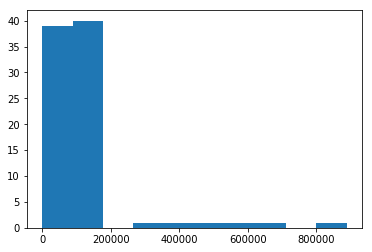

In [12]:
# Plot histogram of NaN counts
plt.hist(feat_info_clean['nan_count']);

In [13]:
# Investigate patterns in the amount of missing data in each column.

# Function to determine outlier threshold for NaN counts
def outlier_thresh(df):
    Q1 = df['nan_count'].quantile(0.25)
    Q3 = df['nan_count'].quantile(0.75)
    IQR = Q3 - Q1
    threshold = IQR + (IQR * 1.5)
    
    return threshold

In [14]:
# Calculate outlier threshold
feat_thresh = outlier_thresh(feat_info_clean)

# Determine attributes with outlier NaN counts
outlier_attrs = feat_info_clean[feat_info_clean.nan_count > feat_thresh]

# Show attributes with outlier NaN counts
outlier_attrs

,attribute,information_level,type,missing_or_unknown,nan_count
0,AGER_TYP,person,categorical,"[-1,0]",685843
11,GEBURTSJAHR,person,numeric,[0],392318
40,TITEL_KZ,person,categorical,"[-1,0]",889061
43,ALTER_HH,household,interval,[0],310267
47,KK_KUNDENTYP,household,categorical,[-1],584612
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]",476524


In [15]:
# Number of records for each estimated age group
azdias_clean.ALTERSKATEGORIE_GROB.value_counts()

3.0    358533
4.0    228510
2.0    158410
1.0    142887
Name: ALTERSKATEGORIE_GROB, dtype: int64

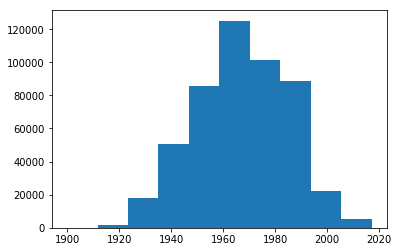

In [16]:
# Distribution of birth years
yobs = azdias_clean.query('GEBURTSJAHR == GEBURTSJAHR') # Removing rows with NaN in YoB for plotting
plt.hist(yobs['GEBURTSJAHR']);

In [17]:
azdias_clean.KBA05_BAUMAX.value_counts()

1.0    208417
5.0     98923
3.0     59955
4.0     37718
2.0      9684
Name: KBA05_BAUMAX, dtype: int64

In [18]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

drop_labels = outlier_attrs['attribute'].tolist()

azdias_clean.drop(columns = drop_labels, inplace = True)

# Confirm outlier attributes dropped, should return ((891221, 79), (79, 5))
azdias_clean.shape, feat_info_clean.shape

((891221, 79), (85, 5))

#### Discussion 1.1.2: Assess Missing Data in Each Column

Six of the 85 features of the dataset had enough NaN values to be classified as outliers. Of these, three contained data about the individual, two about the individual's household, and one about the microcell<sup>1</sup> service area the individual resides in. Taking a closer look at these features may provide clues as to why they contain so many missing data points.

**AGER_TYP**
*Best-ager typology*

This feature aims to classify the lifestyle of elderly individuals. Looking at the estimated age groups (ALTERSKATEGORIE_GROB) in our dataset, we see that these missing values are likely due to the majority of the individuals in the dataset do not qualify as eldery. 662,711 individuals in the set are estimated to be age 60 or under, strongly correlating with the 685,843 missing values in this column.


**GEBURTSJAHR**
*Year of birth*

The year in which the individual was born. It's difficult to determine from the data available why this feature contains so many missing values, but plotting a histogram does seem to imply that these missing values are more likely to be for individuals born during or after the year 2000. The distribution on the plot is largely normal, but a steep drop exists after the bin for 1990-1999.


**TITEL_KZ**
*Academic title flag*

This feature denotes any academic titles (e.g. Professor, Doctor) the individual has attained. It is likely that most of the missing values in this column are due to the individual not having achieved such a title.


**ALTER_HH**
*Birthdate of head of household*

This feature describes the rough age of the head of a given household. The data available gives very little insight into why this feature has so many missing values, but a likely culprit is the head of household criteria. Unfortunately, without knowing what those criteria are, we cannot say with any certainty.


**KK_KUNDENTYP**
*Consumer pattern over past 12 months*

How active this household is as a customer. Much like the previous attribute, without knowing the criteria by which the customer activity level is categorized, it is difficult to determine the cause of the large number of missing values.


**KBA05_BAUMAX**
*Most common building type within the microcell*

Again, without additional data relating to this feature, it difficult to know why there are so many missing values. However, one possible explanation is revealed by the data dictionary. The categories for this feature all describe either purely residential or purely commercial-use buildings. It is possible that mixed-use buildings in the microcell area were categorized as unknowns.

##### Footnotes
1) A small mobile phone base station connected to the phone network via the internet, typically used to improve mobile phone reception within a particular area. - Oxford Languages

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [19]:
# How much data is missing in each row of the dataset?

# Count NaNs in each row and save to new attribute
azdias_clean['nan_count'] = azdias_clean.isnull().sum(axis=1)

# Print summary statistics of new attribute
azdias_clean.nan_count.describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
Name: nan_count, dtype: float64

In [20]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Calculate outlier threshold
row_thresh = outlier_thresh(azdias_clean)

# Split data into subsets
azdias_low_nan = azdias_clean[azdias_clean.nan_count <= row_thresh].copy()
azdias_high_nan = azdias_clean[azdias_clean.nan_count > row_thresh].copy()

In [21]:
# Compare dataset sizes
azdias_low_nan.shape, azdias_high_nan.shape

((747109, 80), (144112, 80))

In [22]:
# Function to compare distributions between subsets
def subset_compare(subset1, subset2, attr):
    plt.figure()
    
    # Plot for subset 1
    plt.subplot(1, 2, 1)
    sns.countplot(x = attr, data = subset1)
    
    # Plot for subset 2
    plt.subplot(1, 2, 2)
    sns.countplot(x = attr, data = subset2)
    
    plt.subplots_adjust(bottom=0.1, right=1.5, top=0.9)
    plt.show()

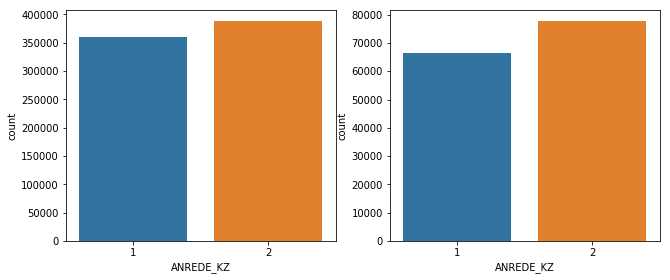

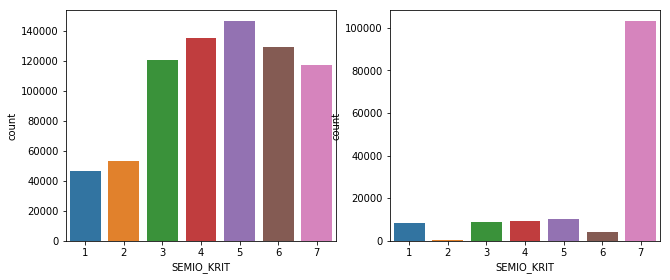

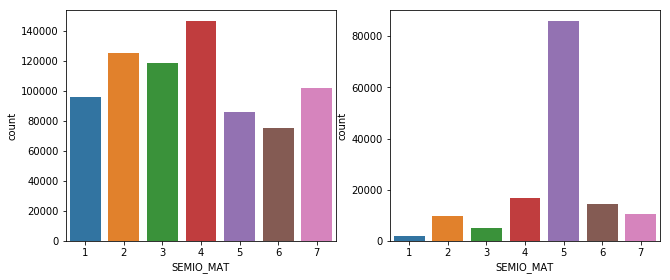

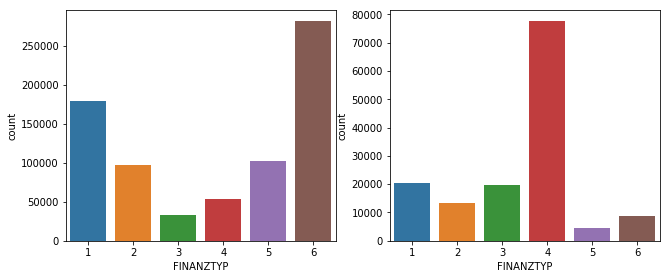

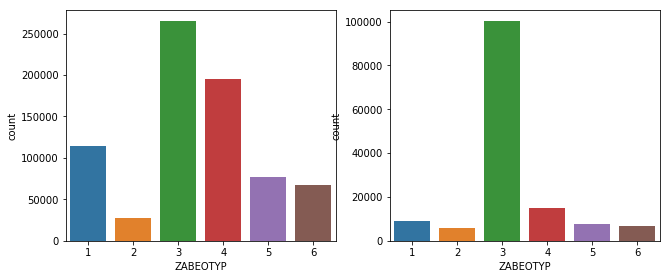

In [23]:
# Chosen columns: ANREDE_KZ, FINANZ_ANLEGER, FINANZ_HAUSBAUER, GREEN_AVANTGARDE, ZABEOTYP
col_list = ['ANREDE_KZ', 'SEMIO_KRIT', 'SEMIO_MAT', 'FINANZTYP', 'ZABEOTYP']

for column in col_list:
    subset_compare(azdias_low_nan, azdias_high_nan, column)

#### Discussion 1.1.3: Assess Missing Data in Each Row

Aside from sex, there do appear to be significant differences between the records with lots of missing values and those with fewer. Below is an analysis of the differences for each attribute.

**ANREDE_KZ**

*Sex*

Both subsets contain more female customers than male, with the difference in proportion being somewhat (though not significantly) larger in the high NaN subset.


**SEMIO_KRIT**

*Critical-mindedness*

This feature measures an individual's critical-mindedness on a scale of 1 to 7, with 1 being the highest. In the low NaN subset, there's a roughly normal distribution across the scale, though with a noticable dropoff for 1s and 2s. The overwhelming majority of the high NaN subset, on the other hand, is made up of individuals with a 7.


**SEMIO_MAT**

*Materialism*

This feature measures an individual's materialism on a scale of 1 to 7, with 1 being the highest. The distribution for the low NaN subset isn't quite normal, but it's also not skewed in either direction. Scores of 4, 2, and 3 (in that order) are the most common, together representing roughly half of the subset. Meanwhile, the high NaN subset is prediominantly individuals with a score of 5, the second least common score in the low NaN set.


**FINANZTYP**

*Most descriptive financial type*

This feature categorizes individuals according to the best description of their overall financial situation/strategy. The categories are as follows:

1. MINIMALIST - Low financial interest
2. SPARER - Money-saver
3. HAUSBAUER - Homeowner
4. VORSORGER - Be prepared
5. ANLEGER - Investor
6. UNAUFFAELLIGER - Inconspicuous

In the low NaN set, we see that most individuals don't appear to be very money-focused, being categorized in either category 6 (inconspicuous) or 1 (low financial interest). By comparison, the majority of individuals in the high NaN subset are category 4 (be prepared) and also have a higher proportion of homeowners (category 3).


**ZABEOTYP**

*Energy consumption typology*

This feature categorizes individuals according to the best description of their energy consumption habits. The categories are as follows:

1. Green
2. Smart
3. Fair supplied
4. Price driven
5. Seeking orientation
6. Indifferent

In both subsets most individuals fall into category 3, indicating a preference for fair business practices over factors such as environmental concerns and price. However, the low NaN set has a larger proportion of individuals who do seem to favor those factors, with more categories 1 and 4 comprising a larger portion of the subset.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [24]:
# How many features are there of each data type?

feat_info_clean.type.value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

**Binary Categoricals**

1. ANREDE_KZ
2. GREEN_AVANTGARDE
3. SOHO_KZ
4. VERS_TYP
5. OST_WEST_KZ - Needs re-encoded

**Multi-level Categoricals**

1. CJT_GESAMTTYP - Categories: 6
2. FINANZTYP - Categories: 6
3. GFK_URLAUBERTYP - Categories: 12
4. LP_FAMILIE_FEIN - Categories: 11
5. LP_FAMILIE_GROB - Categories: 5
6. LP_STATUS_FEIN - Categories: 10
7. LP_STATUS_GROB - Categories: 5
8. NATIONALITAET_KZ - Categories: 3
9. SHOPPER_TYP - Categories: 4
10. ZABEOTYP - Categories: 6
11. GEBAEUDETYP - Categories: 8
12. CAMEO_DEUG_2015 - Categories: 9
13. CAMEO_DEU_2015 - Categories: 44

In [25]:
# Drop categorical variable(s) to be excluded from the analysis.
drop_labels = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP',
               'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015']

azdias_low_nan.drop(columns = drop_labels, inplace = True)

# Confirm excluded columns dropped, should return (747109, 74)
azdias_low_nan.shape

(747109, 74)

In [26]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Re-encode OST_WEST_KZ to a numeric, 'O' to 0 and 'W' to 1
azdias_low_nan.OST_WEST_KZ.replace({'O':0, 'W':1}, inplace = True)

# Verify re-encoding successfull
azdias_low_nan.OST_WEST_KZ.value_counts()

1    587514
0    159595
Name: OST_WEST_KZ, dtype: int64

In [27]:
# Replace non-typical binary values of 1/2 with 0/1
azdias_low_nan.ANREDE_KZ.replace({1:0, 2:1}, inplace = True)
azdias_low_nan.VERS_TYP.replace({1:0, 2:1}, inplace = True)

# Verify re-encoding successfull
azdias_low_nan[['ANREDE_KZ', 'VERS_TYP']].head()

,ANREDE_KZ,VERS_TYP
1,1,1.0
2,1,0.0
3,1,0.0
4,0,1.0
5,1,1.0


In [28]:
# Re-encode columns that don't need additional engineering
simple_cols = ['LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ',
               'SHOPPER_TYP', 'ZABEOTYP']
azdias_low_nan = pd.get_dummies(azdias_low_nan, columns = simple_cols, prefix = simple_cols)

# Confirm dummies generated successfully, should return (747109, 92)
azdias_low_nan.shape

(747109, 92)

In [29]:
# Re-encode columns that need additional engineering

# Define function to separate occupancy status from 'GEBAEUDETYP' and assign to new column 'KNOWN_OCCUPANT' 
def set_occupancy(df):
    unknown_occ = [4, 5, 6, 8] # Categories for unknown occupant
    known_occ = [1, 2, 3, 7] # Categories for known occupant

    df['GTYP_KNOWN_OCCUPANT'] = df['GEBAEUDETYP'].apply(lambda x: 0 if x in unknown_occ
                                          else (1 if x in known_occ else np.nan))

In [30]:
# Create and assign new feature 'KNOWN_OCCUPANT'
set_occupancy(azdias_low_nan)

# Confirm new column created successfully
azdias_low_nan.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GTYP_KNOWN_OCCUPANT
1,1.0,1,1,5,2,5,4,5,0,3.0,...,0,0,1,0,0,0,0,1,0,0
2,3.0,1,1,4,1,2,3,5,1,3.0,...,0,1,0,0,0,0,0,1,0,1
3,4.0,1,4,2,5,2,1,2,0,2.0,...,1,0,0,0,0,1,0,0,0,1
4,3.0,0,4,3,4,1,3,2,0,3.0,...,0,1,0,0,0,0,1,0,0,1
5,1.0,1,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,1,0,0,1


In [31]:
# Define function to create dummies for the three building types
def build_type_dummies(df):
    # Arrays of values corresponding to each building type
    residential = [1, 2]
    commercial = [5, 7]
    mixed_use = [3, 4, 6, 8]
    
    # Lambda functions to assign dummies
    df['GTYP_RESIDENTIAL'] = df['GEBAEUDETYP'].apply(lambda x: 1 if x in residential
                                          else (0 if (x in commercial) | (x in mixed_use) else np.nan))
    df['GTYP_COMMERCIAL'] = df['GEBAEUDETYP'].apply(lambda x: 1 if x in commercial
                                          else (0 if (x in residential) | (x in mixed_use) else np.nan))
    df['GTYP_MIXED_USE'] = df['GEBAEUDETYP'].apply(lambda x: 1 if x in mixed_use
                                          else (0 if (x in commercial) | (x in residential) else np.nan))

In [32]:
# Create dummies for building type
build_type_dummies(azdias_low_nan)

# Confirm new columns created successfully
azdias_low_nan.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GTYP_KNOWN_OCCUPANT,GTYP_RESIDENTIAL,GTYP_COMMERCIAL,GTYP_MIXED_USE
1,1.0,1,1,5,2,5,4,5,0,3.0,...,0,0,0,0,1,0,0,0,0,1
2,3.0,1,1,4,1,2,3,5,1,3.0,...,0,0,0,0,1,0,1,1,0,0
3,4.0,1,4,2,5,2,1,2,0,2.0,...,0,0,1,0,0,0,1,1,0,0
4,3.0,0,4,3,4,1,3,2,0,3.0,...,0,0,0,1,0,0,1,1,0,0
5,1.0,1,3,1,5,2,2,5,0,3.0,...,0,0,0,1,0,0,1,1,0,0


In [33]:
# Case/switch function to map categorical values to ordinal values
def set_ord_val(x):
    if x == 1:
        return 1
    elif x == 2:
        return 2
    elif x in [3, 4, 5, 6]:
        return 3
    elif x == 7:
        return 4
    elif x in [8, 9]:
        return 5
    else:
        return np.nan

# Define function to perform re-encode 'CAMEO_DEUG_2015' as ordinal
def cat_to_ord(df):
    # Convert 'CAMEO_DEUG_2015' from string to numeric
    df['CAMEO_DEUG_2015'] = pd.to_numeric(df['CAMEO_DEUG_2015'])
    
    # Map categorical values with corresponding ordinals
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].map(set_ord_val)

In [34]:
# Re-encode 'CAMEO_DEUG_2015' as ordinal
cat_to_ord(azdias_low_nan)

# Confirm new values assigned correctly
# Should return 325771 for 3.0 and 232032 for 5.0
azdias_low_nan.CAMEO_DEUG_2015.value_counts()

3.0    325771
5.0    232032
2.0     77338
4.0     74244
1.0     34493
Name: CAMEO_DEUG_2015, dtype: int64

#### Discussion 1.2.1: Re-Encode Categorical Features

##### Kept Features

Of the 18 categorical features in the dataset, 12 were kept. The names, details, and any engineering and re-encoding steps for these features are listed below.

*Binary Features*

Four of the five binary features did not need any sort of engineering. They are as follows:

1. ANREDE_KZ - Gender
2. GREEN_AVANTGARDE - Membership in environmental sustainability as part of youth
3. SOHO_KZ - Small office / home office flag
4. VERS_TYP - Insurance typology

The remaining binary feature, 'OST_WEST_KZ', is the one that needed engineering. The feature indicates whether an individual resided in East or West Germany prior to reunification in 1990, with an 'O' (from 'Ost', the German word for 'East') for East Germany and a 'W' for West Germany. Re-encoding was performed using a series replace() function with a value dictionary and the inplace argument set to 'True'. After re-encoding, East Germany is now represented with a '0' and West Germany with a '1'.

Additionally, two of the binary categorical features in the dataset do not use typical 0/1 values. These features ('ANREDE_KZ' & 'VERS_TYP') will be re-encoded using 0/1 values to prevent weighting issues in analysis and because having binary values that aren't 0/1 just kind of annoys me.

*Multi-level Features*

Five of the seven multi-level features could be re-encoded by simply using Pandas' get_dummies() function. They are as follows:

1. LP_FAMILIE_GROB - Family type, rough scale
2. LP_STATUS_GROB - Social status, rough scale
3. NATIONALITAET_KZ - Nationality based on given name analysis
4. SHOPPER_TYP - Shopper typology
5. ZABEOTYP - Energy consumption typology

The remaining two and the steps taken to engineer and encode them are as follows:

1. GEBAEUDETYP - Type of building (residential vs. commercial)

This feature holds two pieces of data: building use type and known occupancy status. In order to generate the dummies, these two data points must be separated. To achieve this, I first ran a lambda function assigning known occupancy status to a new column 'GTYP_KNOWN_OCCUPANT'. The function returned '0' for any of the four categories indicating no known occupant (4-6, & 8), '1' for the remaining categories, and NaNs where appropriate.

To create the remaining dummies, I defined a function build_type_dummies() that takes the dataframe as an argument. The function first defines three arrays, one for each building type, containing the corresponding category codes. Then it runs three lambda functions, each creating a new column for a particular building type and assigning it based on which of the three arrays contains the value of 'GEBAEUDETYP' for that record or a NaN if applicable.

The final result of this engineering is four new binary features:

    1. GTYP_KNOWN_OCCUPANT
    2. GTYP_RESIDENTIAL
    3. GTYP_COMMERCIAL
    4. GTYP_MIXED_USE
    
Each new feature contains the prefix 'GTYP_' to indicate its derivation from 'GEBAEUDETYP'.

2. CAMEO_DEUG_2015 - German CAMEO<sup>2</sup>: Wealth / Life Stage Typology, rough scale

This feature is already very close to being usable as an ordinal. By consolidating the poorly-differentiated categories 3-6 (as all are middle class, no upper or lower) and both working class categories, the feature can be re-encoded with ordinal values indicating economic class in descending order. The ordinal scale would be as shown below:

    1. Upper Class
    2. Upper Middle Class
    3. Middle Class
    4. Lower Middle Class
    5. Working Class

This transformation uses two functions. The first, set_ord_val(), takes the categorical value as an argument and uses an if/elif chain to return either the appropriate ordinal value or a NaN. The second, cat_to_ord(), takes the dataframe as an argument, casts 'CAMEO_DEUG_2015' as a numeric, and then re-encodes the column by mapping it with set_ord_val().

##### Dropped Features

Six of the categorical features in dataset were dropped. The features and the reasoning behind their exclusion are listed below.

    1. CJT_GESAMTTYP - Preferred information and buying channels for consumer
    
Like 'GEBAEUDETYP', this feature contains two pieces of data: preferred information channel and preferred buying channel. Unlike 'GEBAEUDETYP', however, the way the categories are defined makes it difficult, if not impossible, to split them without losing information. Instead of each category being one tuple in a matrix of the two data points, preferred information channel is directly tied to preferred buying channel. This inevitable data loss means trying to separate these will likely not aid with analysis.

    2. FINANZTYP - Most descriptive financial type

The dataset already contains features measuring individuals' affinity for each of the categories on an ordinal scale. As such, creating binary dummies for this feature would be redundant.

    3. GFK_URLAUBERTYP - Vacation habits

The categories for this feature are poorly-defined and often overlap. What differentiates a 'nature fan' from a 'hiker'? Or 'family-oriented vacationists' from 'active families'? This ambiguity makes any conclusions drawn from analysis unreliable.

    4, 5. LP_FAMILIE_FEIN & LP_STATUS_FEIN - Life stage, fine scale & Family type, fine scale

Both of these features are rendered largely redundant by their rough scale counterparts (i.e. 'LP_FAMILIE_GROB' & 'LP_STATUS_GROB'). While they do possess more detail than the rough scale features, it would be prudent to ignore them in the first round of analysis and bring them into consideration for later analyses should trends exist within rough scale features. As an example, if the first round of analysis shows that families are more likely to be customers, later analyses could use the fine scale to look for trends based on family composition (i.e. age of child/children).

    6. CAMEO_DEU_2015 - German CAMEO: Wealth / Life Stage Typology, detailed scale

This feature suffers from both the poorly-defined and overlapping categories of 'GFK_URLAUBERTYP' and the redundancy due to the presence of a corresponding rough scale feature, much like 'LP_FAMILIE_FEIN' & L'P_STATUS_FEIN'. Another reason to drop this feature is the sheer scale of it. With 44 categories, creating and analyzing the binary dummies would be tedious and time-consuming. Add to that the issues of redundancy and ambiguity and keeping this feature would be a large amount of work with very little benefit.

##### Update Data Dictionary

To reflect the changes made during cleaning and re-encoding, I have created an updated data dictionary and uploaded it to workspace. To view the new dictionary, open file 'Updated Data Dictionary.txt'.

*Footnotes*
2. "CAMEO profiles from the TransUnion Information Group provide consumer classification systems that indicate the socio-economic and geo-demographic profiles of neighborhoods across the world." - Informatica, https://docs.informatica.com/data-as-a-service/address-verification-(on-premises)/5-16-0/developer-guide--on-premises-/address-enrichments/cameo-consumer-segmentation.html

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [35]:
# Investigate mixed features

feat_info_clean.query('type == "mixed"')

,attribute,information_level,type,missing_or_unknown,nan_count
15,LP_LEBENSPHASE_FEIN,person,mixed,[0],97632
16,LP_LEBENSPHASE_GROB,person,mixed,[0],94572
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]",108164
56,WOHNLAGE,building,mixed,[-1],93148
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]",99352
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]",476524
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]",116515


In [36]:
# Drop mixed variable(s) to be excluded from the analysis.
drop_labels = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE']

azdias_low_nan.drop(columns = drop_labels, inplace = True)

# Confirm excluded columns dropped, should return (747109, 94)
azdias_low_nan.shape

(747109, 93)

In [37]:
# Investigate "PRAEGENDE_JUGENDJAHRE"

azdias_low_nan.PRAEGENDE_JUGENDJAHRE.value_counts()

14.0    172952
8.0     134165
5.0      81722
10.0     80527
3.0      51784
15.0     39536
11.0     33173
9.0      32493
6.0      25120
12.0     23337
4.0      20068
1.0      19583
2.0       7340
13.0      5300
7.0       3888
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [38]:
# Define functions to engineer new features from 'PRAEGENDE_JUGENDJAHRE'

# Case/Switch function to return movement type for category
def set_move_typ(x):
    if x in [1, 3, 5, 8, 10, 12, 14]:
        return 0 # Mainstream
    elif x in [2, 4, 6, 7, 9, 11, 13, 15]:
        return 1 #Avantegarde
    else:
        return np.nan

# Case/Switch function to return decade for category
def set_decade(x):
    if x in [1, 2]:
        return 40
    elif x in [3, 4]:
        return 50
    elif x in [5, 6, 7]:
        return 60
    elif x in [8, 9]:
        return 70
    elif x in [10, 11, 12, 13]:
        return 80
    elif x in [14, 15]:
        return 90
    else:
        return np.nan

# Define function to create and assign new variables
def split_pj(df):
    # Create new variable 'PJ_MOVETYP' and assign by mapping with function set_move_typ
    df['PJ_MOVETYP'] = df['PRAEGENDE_JUGENDJAHRE'].map(set_move_typ)
    
    # Create new variable 'PJ_DECADE' and assign by mapping with function set_decade
    df['PJ_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map(set_decade)

In [39]:
# Re-encode 'PRAEGENDE_JUGENDJAHRE' as two vairables 'PJ_MOVETYP' & 'PJ_DECADE'
split_pj(azdias_low_nan)

# Confirm new values assigned correctly
azdias_low_nan.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GTYP_KNOWN_OCCUPANT,GTYP_RESIDENTIAL,GTYP_COMMERCIAL,GTYP_MIXED_USE,PJ_MOVETYP,PJ_DECADE
1,1.0,1,1,5,2,5,4,5,0,3.0,...,0,0,1,0,0,0,0,1,0.0,90.0
2,3.0,1,1,4,1,2,3,5,1,3.0,...,0,0,1,0,1,1,0,0,1.0,90.0
3,4.0,1,4,2,5,2,1,2,0,2.0,...,1,0,0,0,1,1,0,0,0.0,70.0
4,3.0,0,4,3,4,1,3,2,0,3.0,...,0,1,0,0,1,1,0,0,0.0,70.0
5,1.0,1,3,1,5,2,2,5,0,3.0,...,0,1,0,0,1,1,0,0,0.0,50.0


In [40]:
# Investigate "CAMEO_INTL_2015"

azdias_low_nan.CAMEO_INTL_2015.head()

1    51
2    24
3    12
4    43
5    54
Name: CAMEO_INTL_2015, dtype: object

In [41]:
# Define function to split 'CAMEO_INTL_2015' into two new features
def split_cameo_intl(df):
    # Assign first digit of 'CAMEO_INTL_2015' to 'CI_WEALTH'
    df['CI_WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x: int(x[0]) if pd.notna(x) else np.nan)
    
    # Assign second digit of 'CAMEO_INTL_2015' to 'CI_HOUSEHOLD'
    df['CI_HOUSEHOLD'] = df['CAMEO_INTL_2015'].apply(lambda x: int(x[1]) if pd.notna(x) else np.nan)

In [42]:
# Split 'CAMEO_INTL_2015' into new variables
split_cameo_intl(azdias_low_nan)

# Confirm new features assigned correctly
# First row should have 5.0 in 'CI_WEALTH' and 1.0 in 'CI_HOUSEHOLD'
azdias_low_nan.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,ZABEOTYP_5,ZABEOTYP_6,GTYP_KNOWN_OCCUPANT,GTYP_RESIDENTIAL,GTYP_COMMERCIAL,GTYP_MIXED_USE,PJ_MOVETYP,PJ_DECADE,CI_WEALTH,CI_HOUSEHOLD
1,1.0,1,1,5,2,5,4,5,0,3.0,...,1,0,0,0,0,1,0.0,90.0,5.0,1.0
2,3.0,1,1,4,1,2,3,5,1,3.0,...,1,0,1,1,0,0,1.0,90.0,2.0,4.0
3,4.0,1,4,2,5,2,1,2,0,2.0,...,0,0,1,1,0,0,0.0,70.0,1.0,2.0
4,3.0,0,4,3,4,1,3,2,0,3.0,...,0,0,1,1,0,0,0.0,70.0,4.0,3.0
5,1.0,1,3,1,5,2,2,5,0,3.0,...,0,0,1,1,0,0,0.0,50.0,5.0,4.0


In [43]:
# Define function to consolidate residential subcategories
def merge_subcats(df):
    subcats = [1, 2, 3, 4] # Residential subcategories
    
    # Replace residential subcats with '0', commercial with '1'
    df['PLZ8_BAUMAX'] = df['PLZ8_BAUMAX'].apply(lambda x: 0 if (x in subcats) else
                                                  (1 if x == 5 else np.nan))

In [44]:
# Merge subcats and re-encode
merge_subcats(azdias_low_nan)

# Confirm re-encoding successful
azdias_low_nan['PLZ8_BAUMAX'].head()

1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
Name: PLZ8_BAUMAX, dtype: float64

#### Discussion 1.2.2: Engineer Mixed-Type Features

##### Kept Features

1. PRAEGENDE_JUGENDJAHRE - Dominating movement of person's youth

This feature is transformed using three functions. The first two, set_move_typ() and set_decade(), take the categorical value as an argument and use an if/elif chain to return either the appropriate value or a NaN. The third, split_pj(), takes the dataframe as an argument, and assigns the correct values to columns 'PJ_MOVETYP' and 'PJ_DECADE' by mapping them by their respective functions.

The new features contain the prefix 'PJ_' to indicate their derivation from 'PRAEGENDE_JUGENDJAHRE'.

2. CAMEO_INTL_2015 - German CAMEO: Wealth / Life Stage Typology, mapped to international code

This feature's original data format made engineering very simple. The original values are all strings of two digits. Each digit is an independent ordinal value, with the first corresponding to wealth and the second to household makeup. To split these, a function split_cameo_intl() was defined, taking the dataframe as its argument. Then a lambda function assigns 'CI_WEALTH' with either a NaN or the first character of the string cast to an integer. Another lambda then does the same for 'CI_HOUSEHOLD' and the second character.

The new features contain the prefix 'CI_' to indicate their derivation from 'CAMEO_INTL_2015'.

3. PLZ8_BAUMAX - Most common building type within the PLZ8 region

This feature tracks whether the most common building type in the area is commercial or residential and, if residential, how many families are expected to occupy the building. The commonality of the residential subtypes is already tracked in features 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', and 'PLZ8_ANTG4', making this part of 'PLZ8_BAUMAX' redundant. By using a lambda function to consolidate the residential subtypes, this feature can be re-engineered as a binary between residential and commercial.

##### Dropped Features

    1, 2. LP_LEBENSPHASE_FEIN & LP_LEBENSPHASE_GROB - Life stage, fine scale & Life stage, rough scale
    
Every data point captured by these features (wealth, age, family structure, home ownership) is captured in other features of the dataset. Re-engineering these features would garner no additional insight.

    3. WOHNLAGE - Neighborhood quality (or rural flag)
    
While this feature is intended to capture both the quality of a neighborhood and whether that neighborhood is rural or urban, not enough levels exist to separate the rural/urban attribute. Removing the two rural categories and leaving the others unchanged neatly turns this feature into an ordinal. However, removing these categories results in a total of 174092 missing values in the column. This is well above the threshold established during cleaning, so the feature is dropped.
    
    4. KBA05_BAUMAX - Most common building type within the microcell
    
This feature was already dropped earlier in cleaning due to its large number of missing values.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [45]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Drop categorical variables made redundant by wrangling
drop_labels = ['GEBAEUDETYP', 'PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']

azdias_low_nan.drop(columns = drop_labels, inplace = True)

# Confirm excluded columns dropped, should return (747109, 95)
azdias_low_nan.shape

(747109, 94)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [46]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    df_clean = df
    feat_info_clean = feat_info
    
    # Put in code here to execute all main cleaning steps:
    
    # Convert missing value codes into NaNs
    # Mentor code, see student note in section 1.1.1:
    for attribute, miss_index in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
        missing_values = miss_index.strip('[]').split(',')
        missing_values = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_values]
        if missing_values != ['']:
            df_clean[attribute] = df_clean[attribute].replace(missing_values, np.nan)
    
    # Remove selected columns and rows
    # Function to determine outlier threshold for NaN counts
    def outlier_thresh(frame):
        Q1 = frame['nan_count'].quantile(0.25)
        Q3 = frame['nan_count'].quantile(0.75)
        IQR = Q3 - Q1
        threshold = IQR + (IQR * 1.5)
        
        return threshold
    
    # Count NaN totals per feature and save to new column
    nan_counts = []
    for col in df_clean.columns:
        nan_counts.append(df_clean[col].isna().sum())
    feat_info_clean['nan_count'] = nan_counts
    
    # Remove columns with high NaN counts
    feat_thresh = outlier_thresh(feat_info_clean)
    outlier_attrs = feat_info_clean[feat_info_clean.nan_count > feat_thresh]
    drop_labels = outlier_attrs['attribute'].tolist()
    df.drop(columns = drop_labels, inplace = True)
    
    # Count NaN totals per row and save to new column
    df_clean['nan_count'] = df_clean.isnull().sum(axis=1)
    
    # Remove rows with high NaN counts
    row_thresh = outlier_thresh(df_clean)
    df_low_nan = df[df_clean.nan_count <= row_thresh].copy()
    
    # Select, re-encode, and engineer column values
    # Remove features deemed not suitable for analysis
    drop_labels = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN',
                   'CAMEO_DEU_2015', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE']
    df_low_nan.drop(columns = drop_labels, inplace = True)

    # Re-encode columns that don't need additional engineering
    simple_cols = ['LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ',
                   'SHOPPER_TYP', 'ZABEOTYP']
    df_low_nan = pd.get_dummies(df_low_nan, columns = simple_cols, prefix = simple_cols)
    
    # Re-encode OST_WEST_KZ to a numeric, 'O' to 0 and 'W' to 1
    df_low_nan.OST_WEST_KZ.replace({'O':0, 'W':1}, inplace = True)
    
    # Replace non-typical binary values of 1/2 with 0/1
    df_low_nan.ANREDE_KZ.replace({1:0, 2:1}, inplace = True)
    df_low_nan.VERS_TYP.replace({1:0, 2:1}, inplace = True)
    
    # Define functions used to re-encode features needing additional engineering
    def set_occupancy(frame):
        unknown_occ = [4, 5, 6, 8] # Categories for unknown occupant
        known_occ = [1, 2, 3, 7] # Categories for known occupant
        frame['GTYP_KNOWN_OCCUPANT'] = frame['GEBAEUDETYP'].apply(lambda x: 0 if x in unknown_occ
                                              else (1 if x in known_occ else np.nan))
    
    def build_type_dummies(frame):
        # Arrays of values corresponding to each building type
        residential = [1, 2]
        commercial = [5, 7]
        mixed_use = [3, 4, 6, 8]
        
        # Lambda functions to assign dummies
        frame['GTYP_RESIDENTIAL'] = frame['GEBAEUDETYP'].apply(lambda x: 1 if x in residential
                                              else (0 if (x in commercial) | (x in mixed_use) else np.nan))
        frame['GTYP_COMMERCIAL'] = frame['GEBAEUDETYP'].apply(lambda x: 1 if x in commercial
                                              else (0 if (x in residential) | (x in mixed_use) else np.nan))
        frame['GTYP_MIXED_USE'] = frame['GEBAEUDETYP'].apply(lambda x: 1 if x in mixed_use
                                              else (0 if (x in commercial) | (x in residential) else np.nan))
    
    def set_ord_val(x):
        if x == 1:
            return 1
        elif x == 2:
            return 2
        elif x in [3, 4, 5, 6]:
            return 3
        elif x == 7:
            return 4
        elif x in [8, 9]:
            return 5
        else:
            return np.nan
    
    def cat_to_ord(frame):
        # Convert 'CAMEO_DEUG_2015' from string to numeric
        frame['CAMEO_DEUG_2015'] = pd.to_numeric(frame['CAMEO_DEUG_2015'])
        
        # Map categorical values with corresponding ordinals
        frame['CAMEO_DEUG_2015'] = frame['CAMEO_DEUG_2015'].map(set_ord_val)

    def set_move_typ(x):
        if x in [1, 3, 5, 8, 10, 12, 14]:
            return 0 # Mainstream
        elif x in [2, 4, 6, 7, 9, 11, 13, 15]:
            return 1 #Avantegarde
        else:
            return np.nan

    def set_decade(x):
        if x in [1, 2]:
            return 40
        elif x in [3, 4]:
            return 50
        elif x in [5, 6, 7]:
            return 60
        elif x in [8, 9]:
            return 70
        elif x in [10, 11, 12, 13]:
            return 80
        elif x in [14, 15]:
            return 90
        else:
            return np.nan

    def split_pj(frame):
        # Create new variable 'PJ_MOVETYP' and assign by mapping with function set_move_typ
        frame['PJ_MOVETYP'] = frame['PRAEGENDE_JUGENDJAHRE'].map(set_move_typ)
        
        # Create new variable 'PJ_DECADE' and assign by mapping with function set_decade
        frame['PJ_DECADE'] = frame['PRAEGENDE_JUGENDJAHRE'].map(set_decade)
    
    def split_cameo_intl(frame):
        # Assign first digit of 'CAMEO_INTL_2015' to 'CI_WEALTH'
        frame['CI_WEALTH'] = frame['CAMEO_INTL_2015'].apply(lambda x: int(x[0]) if pd.notna(x) else np.nan)
        
        # Assign second digit of 'CAMEO_INTL_2015' to 'CI_HOUSEHOLD'
        frame['CI_HOUSEHOLD'] = frame['CAMEO_INTL_2015'].apply(lambda x: int(x[1]) if pd.notna(x) else np.nan)
    
    def merge_subcats(frame):
        subcats = [1, 2, 3, 4] # Residential subcategories
        
        # Replace residential subcats with '0', commercial with '1'
        frame['PLZ8_BAUMAX'] = frame['PLZ8_BAUMAX'].apply(lambda x: 0 if (x in subcats) else
                                                  (1 if x == 5 else np.nan))
    
    # Call re-encoding/engineering functions
    set_occupancy(df_low_nan)
    build_type_dummies(df_low_nan)
    cat_to_ord(df_low_nan)
    split_pj(df_low_nan)
    split_cameo_intl(df_low_nan)
    merge_subcats(df_low_nan)
    
    # Drop features made redundant by re-encoding/engineering
    drop_labels = ['GEBAEUDETYP', 'PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']
    df_low_nan.drop(columns = drop_labels, inplace = True)
    
    # Return the cleaned dataframe
    return df_low_nan

In [47]:
# Testing cell to confirm cleaning function works as intended
# Should return (747109, 94)
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

azdias_clean = clean_data(azdias)
azdias_clean.shape

(747109, 94)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

#### Step 2.1.1: Address Remaining NaNs

Investigate any remaining missing values and either replace with imputation or remove the data point. 

In [48]:
# Investigate remaining missing values

# Define function to count missing values for each feature
def remaining_nans(df):
    # Count missing values remaining in each feature
    nan_counts = []
    for col in df.columns:
        nan_counts.append(df[col].isna().sum())
        
    # Create dataframe containing feature names and corresponding NaN counts
    new_df = pd.DataFrame(columns = ['Feature', "Remaining_Nans"])
    new_df['Feature'] = df.columns
    new_df['Remaining_Nans'] = nan_counts
    new_df = new_df.query('Remaining_Nans > 0').copy() # Drop rows where Remaining_Nans is 0
    new_df.sort_values(by = ['Remaining_Nans'], ascending = False, inplace = True) # Sort highest to lowest
    
    return new_df

In [49]:
# Generate dataframe with remaining NaN counts
nans_remain_df = remaining_nans(azdias_clean)

# Print dataframe
nans_remain_df

,Feature,Remaining_Nans
30,W_KEIT_KIND_HH,45413
47,KKK,40420
50,REGIOTYP,40420
9,HEALTH_TYP,24356
26,VERS_TYP,24356
91,PJ_DECADE,16121
90,PJ_MOVETYP,16121
38,KBA05_ANTG1,10989
48,MOBI_REGIO,10989
40,KBA05_ANTG3,10989


In [50]:
# Confirm features with same number of NaNs have missing values in same rows
# If true, will return Remaining_Nans value shown above

# Investigate 'KKK' & 'REGIOTYP'
print(azdias_clean.query('KKK != KKK & REGIOTYP != REGIOTYP').shape[0]),
# Investigate 'HEALTH_TYP' & 'VERS_TYP'
print(azdias_clean.query('HEALTH_TYP != HEALTH_TYP & VERS_TYP != VERS_TYP').shape[0]),
# Investigate 'MOBI_REGIO' & 'KBA05_ANTG1'
print(azdias_clean.query('MOBI_REGIO != MOBI_REGIO & KBA05_ANTG1 != KBA05_ANTG1').shape[0]),
# Investigate 'PLZ8_BAUMAX' & 'PLZ8_ANTG1'
print(azdias_clean.query('PLZ8_BAUMAX != PLZ8_BAUMAX & PLZ8_ANTG1 != PLZ8_ANTG1').shape[0]),
# Investigate 'ARBEIT' & 'RELAT_AB'
print(azdias_clean.query('ARBEIT != ARBEIT & RELAT_AB != RELAT_AB').shape[0]),
# Investigate 'CAMEO_DEUG_2015' & 'CI_WEALTH'
print(azdias_clean.query('CAMEO_DEUG_2015 != CAMEO_DEUG_2015 & CI_WEALTH != CI_WEALTH').shape[0]),
# Investigate 'BALLRAUM' & 'EWDICHTE'
print(azdias_clean.query('BALLRAUM != BALLRAUM & EWDICHTE != EWDICHTE').shape[0])

40420
24356
10989
2837
3733
3231
485


In [51]:
# Investigate 'W_KEIT_KIND_HH'
azdias_clean.W_KEIT_KIND_HH.value_counts()

6.0    270673
4.0    125888
3.0     89351
2.0     78313
1.0     74289
5.0     63182
Name: W_KEIT_KIND_HH, dtype: int64

In [52]:
# Investigate 'KKK' & 'REGIOTYP'
azdias_clean.KKK.value_counts(), azdias_clean.REGIOTYP.value_counts()

(3.0    263842
 2.0    174321
 4.0    172952
 1.0     95574
 Name: KKK, dtype: int64, 6.0    188221
 5.0    140601
 3.0     90032
 2.0     88170
 7.0     81616
 4.0     65707
 1.0     52342
 Name: REGIOTYP, dtype: int64)

In [53]:
# Investigate 'HEALTH_TYP' & 'VERS_TYP'
azdias_clean.HEALTH_TYP.value_counts(), azdias_clean.VERS_TYP.value_counts()

(3.0    297076
 2.0    279050
 1.0    146627
 Name: HEALTH_TYP, dtype: int64, 1.0    381818
 0.0    340935
 Name: VERS_TYP, dtype: int64)

In [54]:
# Investigate 'MOBI_REGIO' & 'KBA05_ANTG1'
azdias_clean.MOBI_REGIO.value_counts(), azdias_clean.KBA05_ANTG1.value_counts()

(1.0    157660
 3.0    145861
 5.0    145794
 4.0    144880
 2.0    141627
 6.0       298
 Name: MOBI_REGIO, dtype: int64, 0.0    252627
 1.0    154678
 2.0    123597
 3.0    115558
 4.0     89660
 Name: KBA05_ANTG1, dtype: int64)

In [55]:
# Investigate 'PLZ8_BAUMAX' & 'PLZ8_ANTG1'
azdias_clean.PLZ8_BAUMAX.value_counts(), azdias_clean.PLZ8_ANTG1.value_counts()

(0.0    650052
 1.0     94220
 Name: PLZ8_BAUMAX, dtype: int64, 2.0    259668
 3.0    212188
 1.0    183664
 4.0     83386
 0.0      5366
 Name: PLZ8_ANTG1, dtype: int64)

Drop rows with missing values in selected columns.

In [56]:
# Drop rows with missing values
drop_list = ['W_KEIT_KIND_HH', 'KKK', 'HEALTH_TYP', 'MOBI_REGIO', 'PLZ8_ANTG1']
azdias_clean.dropna(subset = drop_list, inplace = True)

# Generate new dataframe with updated remaining NaN counts
nans_remain_df = remaining_nans(azdias_clean)

# Print dataframe
nans_remain_df

,Feature,Remaining_Nans
90,PJ_MOVETYP,6367
91,PJ_DECADE,6367
59,ARBEIT,3472
61,RELAT_AB,3472
60,ORTSGR_KLS9,3402
37,CAMEO_DEUG_2015,2863
92,CI_WEALTH,2863
93,CI_HOUSEHOLD,2863
32,ANZ_HAUSHALTE_AKTIV,1833
51,KBA13_ANZAHL_PKW,591


In [57]:
# Investigate 'PJ_DECADE' & 'PJ_MOVETYP'
azdias_clean.PJ_DECADE.value_counts(), azdias_clean.PJ_MOVETYP.value_counts()

(90.0    180593
 70.0    145589
 80.0    123336
 60.0     97492
 50.0     63346
 40.0     21748
 Name: PJ_DECADE, dtype: int64, 0.0    484017
 1.0    148087
 Name: PJ_MOVETYP, dtype: int64)

In [58]:
# Investigate 'ARBEIT' & 'RELAT_AB'
azdias_clean.ARBEIT.value_counts(), azdias_clean.RELAT_AB.value_counts()

(4.0    258220
 3.0    201661
 2.0    104019
 1.0     42091
 5.0     29008
 Name: ARBEIT, dtype: int64, 3.0    223487
 5.0    144277
 1.0    107304
 2.0     80967
 4.0     78964
 Name: RELAT_AB, dtype: int64)

In [59]:
# Investigate 'ORTSGR_KLS9'
azdias_clean.ORTSGR_KLS9.value_counts(), azdias_clean['ORTSGR_KLS9'].mean()

(5.0    118359
 4.0     89299
 7.0     85388
 9.0     77295
 3.0     63185
 6.0     62782
 8.0     61340
 2.0     46728
 1.0     30693
 Name: ORTSGR_KLS9, dtype: int64, 5.390718173930707)

In [60]:
# Investigate 'CAMEO_DEUG_2015' & 'CI_WEALTH' 'CI_HOUSEHOLD'
azdias_clean.CAMEO_DEUG_2015.value_counts(), azdias_clean.CI_WEALTH.value_counts(),azdias_clean.CI_HOUSEHOLD.value_counts()

(3.0    276375
 5.0    206186
 4.0     63355
 2.0     60232
 1.0     29460
 Name: CAMEO_DEUG_2015, dtype: int64, 5.0    189614
 4.0    158110
 2.0    145743
 1.0     89692
 3.0     52449
 Name: CI_WEALTH, dtype: int64, 1.0    202450
 4.0    191040
 5.0     95944
 3.0     89696
 2.0     56478
 Name: CI_HOUSEHOLD, dtype: int64)

In [61]:
# Investigate 'ANZ_HAUSHALTE_AKTIV'
azdias_clean.ANZ_HAUSHALTE_AKTIV.describe()

count    636638.000000
mean          8.538521
std          15.564810
min           1.000000
25%           2.000000
50%           4.000000
75%          10.000000
max         536.000000
Name: ANZ_HAUSHALTE_AKTIV, dtype: float64

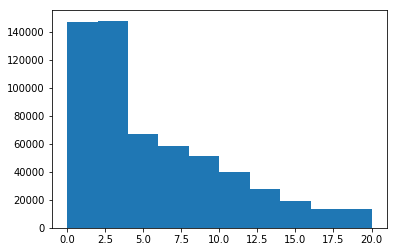

In [62]:
# Investigate 'ANZ_HAUSHALTE_AKTIV' cont
num_hh = azdias_clean.query('ANZ_HAUSHALTE_AKTIV == ANZ_HAUSHALTE_AKTIV') # Removing NaNs for hist plot
plt.hist(num_hh['ANZ_HAUSHALTE_AKTIV'], range = (0, 20)); # Ignoring outliers for plot

In [63]:
# Investigate 'KBA13_ANZAHL_PKW'
azdias_clean.KBA13_ANZAHL_PKW.describe()

count    637880.000000
mean        611.104897
std         332.484457
min           1.000000
25%         381.000000
50%         542.000000
75%         765.000000
max        2300.000000
Name: KBA13_ANZAHL_PKW, dtype: float64

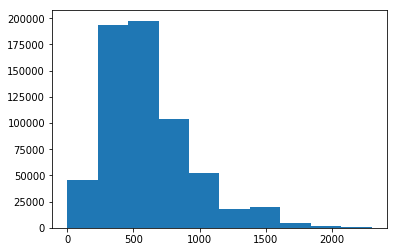

In [64]:
# Investigate 'KBA13_ANZAHL_PKW' cont
num_cars = azdias_clean.query('KBA13_ANZAHL_PKW == KBA13_ANZAHL_PKW') # Removing NaNs for hist plot
plt.hist(num_cars['KBA13_ANZAHL_PKW']);

In [65]:
# Investigate 'BALLRAUM' & 'EWDICHTE' & 'INNENSTADT' cont
azdias_clean.BALLRAUM.value_counts(), azdias_clean.EWDICHTE.value_counts(),azdias_clean.INNENSTADT.value_counts()

(6.0    201551
 1.0    127163
 2.0     84674
 7.0     77929
 3.0     57876
 4.0     48166
 5.0     40670
 Name: BALLRAUM, dtype: int64, 6.0    169501
 5.0    131919
 2.0    106964
 4.0    104918
 3.0     63691
 1.0     61036
 Name: EWDICHTE, dtype: int64, 5.0    114836
 4.0    107539
 2.0     92031
 6.0     87067
 3.0     76995
 8.0     63996
 7.0     52482
 1.0     43083
 Name: INNENSTADT, dtype: int64)

Drop the nan_count column and impute the remaining missing values.

In [66]:
# Impute remaining missing values

# Initialize imputer for each strategy to be used
imp_mf = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent', copy = False)
imp_med = SimpleImputer(missing_values = np.nan, strategy = 'median', copy = False)

# Array of features using most_frequent strategy
mf_cols = ['PJ_DECADE', 'PJ_MOVETYP', 'ARBEIT', 'RELAT_AB', 'ORTSGR_KLS9', 'CAMEO_DEUG_2015', 'CI_WEALTH',
           'CI_HOUSEHOLD', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'KONSUMNAEHE', 'GEBAEUDETYP_RASTER']
# Array of features using median strategy
med_cols = ['ANZ_HAUSHALTE_AKTIV', 'KBA13_ANZAHL_PKW']

# Fit models for imputation
mf_imp_model = imp_mf.fit(azdias_clean[mf_cols])
med_imp_model = imp_med.fit(azdias_clean[med_cols])

In [67]:
# Define function to impute missing values
def imp_missing(df, mf_cols, med_cols):
    # Drop nan_count column before imputation
    df.drop(columns = ['nan_count'], inplace = True)
    
    # Impute selected features
    df[mf_cols] = mf_imp_model.transform(df[mf_cols])
    df[med_cols] = med_imp_model.transform(df[med_cols])

In [68]:
# Impute missing values
imp_missing(azdias_clean, mf_cols, med_cols)

# Final count of NaNs per feature, dataframe should return empty
nans_remain_df = remaining_nans(azdias_clean)
nans_remain_df

,Feature,Remaining_Nans


#### Discussion 2.1.1: Address Remaining NaNs

The decision to impute the missing value or drop the containing records was based on a number of factors. These factors include how many records would be lost if the NaN rows were dropped, whether imputation might introduce bias to the data, and which, if any, imputation strategy is best suited to the feature's variable type.

Missing values are handled according to NaNs per feature in descending order. Features selected to have their missing values dropped will be addressed before any imputation is performed. This is to avoid wasting time and processing power imputing values that will only be discarded later.

##### Missing Values Dropped

    1. W_KEIT_KIND_HH - Likelihood of children in household

With over 45,000 rows with missing values, dropping the missing values in this column would cost us over 6% of the records in our dataset. While this is far from ideal, so are the imputation strategies offered by sklearn. Taking the mean or median of the column values makes little sense given what the feature is measuring, and selecting the most frequent value will likely introduce bias into the data given the how many values are missing.

    2, 3. KKK & REGIOTYP - Purchasing power in region & Neighborhood typology

Conveniently, these two features have missing values in all the same rows. Less conveniently, they are also both unsuited for mean/median imputation and are missing a large enough number of values that using the most frequent value may introduce bias.

    4, 5. HEALTH_TYP & VERS_TYP - Health typology & Insurance typology
    
Again we have two features with missing values in all the same rows. While 'VERS_TYP' could probably be imputed using the most frequent value without introducing significant bias as the margin between its two categories is larger than the number of missing values, the same cannot be said for 'HEALTH_TYP'. Because the margin between the two most frequent categories in 'HEALTH_TYP' is less than the number of missing values, it's very likely that imputation would cause bias in the data.

    6-10. MOBI_REGIO - Movement patterns
    
As with the features listed above, the variable type is unsuited to mean/median imputation and the narrow margin between the two most common values makes using the most frequent one prone to bias. This feature has missing values in all the same rows as features 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', and 'KBA05_ANTG4'. Dropping the missing value rows for this feature will also remove theirs.

    
    11-17. PLZ8 macro-cell features
    
With the exception of 'KBA13_ANZAHL_PKW', all features for the PLZ8 macrocell have missing values in all the same rows. As with the KBA05 microcell features, most of these would suffer bias if imputed. Particularly given that imputation could cause the values of features 'PLZ8_ANTG1' through 'PLZ8_ANTG4' to directly conflict. Though some features in this category (e.g. 'PLZ8_BAUMAX') could be reliably imputed, their missing values will be dropped when those in the other columns are.

##### Missing Values Imputed

The features listed below were selected for imputing because they have few enough missing values that imputation is unlikely to introduce bias. The categorical and ordinal values chosen were also selected because the margin between the first and second most common values is larger than the number of missing values.

Categorical and ordinal features will be imputed using the most frequent strategy, while numeric features will use the median strategy. Median was chosen over mean for the numeric features because, when viewing the distribution of the values on a histogram, the median was closer to distribution's peak.

1. PJ_DECADE
2. PJ_MOVETYP
3. ARBEIT - Share of unemployment in community
4. RELAT_AB - Share of unemployment relative to county in which community is contained
5. ORTSGR_KLS9 - Size of community
6. CAMEO_DEUG_2015 - German CAMEO: Wealth / Life Stage Typology, rough scale
7. CI_WEALTH
8. CI_HOUSEHOLD
9. ANZ_HAUSHALTE_AKTIV - Number of households in the building
10. KBA13_ANZAHL_PKW - Number of cars in the PLZ8 region
11. BALLRAUM - Distance to nearest urban center
12. EWDICHTE - Density of households per square kilometer
13. INNENSTADT - Distance to city center (downtown)
14. KONSUMNAEHE - Distance from building to point of sale (PoS)
15. GEBAEUDETYP_RASTER - Ratio of residential to commercial activity

#### 2.1.2: Apply Feature Scaling

In [69]:
# Define function to identify columns in need of scaling
def find_scale_cols(df):
    # Array to hold column names
    cols_to_scale = []
    
    for col in df.columns:
        if df[col].nunique() > 2: # Check if feature is ordinal/continuous
            cols_to_scale.append(col) # 
            
    return cols_to_scale

In [70]:
# Initialize scaler
scaler = StandardScaler()

# Get columns to fit and fitted model
scale_cols = find_scale_cols(azdias_clean)
scale_model = scaler.fit(azdias_clean[scale_cols])

# Define scaling function
def scale_df(df):
    # Scale selected features
    return scale_model.transform(df[scale_cols])

In [71]:
# Apply feature scaling to the general population demographics data.
azdias_clean[scale_cols] = scale_df(azdias_clean)

# Verify scaling successful
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,ZABEOTYP_5,ZABEOTYP_6,GTYP_KNOWN_OCCUPANT,GTYP_RESIDENTIAL,GTYP_COMMERCIAL,GTYP_MIXED_USE,PJ_MOVETYP,PJ_DECADE,CI_WEALTH,CI_HOUSEHOLD
1,-1.753861,1,-1.519730,1.591354,-1.053362,1.543226,1.055916,1.329388,0,1.052777,...,1,0,0,0,0,1,0.0,1.151503,1.137249,-1.243326
2,0.189735,1,-1.519730,0.911250,-1.772748,-0.525133,0.326927,1.329388,1,1.052777,...,1,0,1,1,0,0,1.0,1.151503,-0.919683,0.753279
4,0.189735,0,0.690050,0.231147,0.385410,-1.214587,0.326927,-0.863110,0,1.052777,...,0,0,1,1,0,0,0.0,-0.223844,0.451605,0.087744
5,-1.753861,1,-0.046543,-1.129060,1.104796,-0.525133,-0.402062,1.329388,0,1.052777,...,0,0,1,1,0,0,0.0,-1.599190,1.137249,0.753279
6,-0.782063,1,-1.519730,1.591354,-1.772748,1.543226,1.055916,-0.132277,0,-0.267497,...,0,0,1,1,0,0,0.0,0.463829,-0.919683,-0.577791


#### Discussion 2.1.2: Apply Feature Scaling

Standardization is applied to all remaining ordinal and continuous and features. Since all binary features use the same scale, they are left as-is. The transformation is peformed via two functions, one nested inside the other. The outer function takes a dataframe its argument and passes it along to the inner function. The inner function then returns an array of all non-binary features (by comparing the number of unique values in each column) to the outer function. The outer function then uses the StandardScaler to fit and transform the dataframe subset defined by the returned array. 

I had considered using MinMax normalization on the ordinal values and only standardizing the continuous ones, but I was unsure how that would impact the analysis. Cursory research on stackexchange and other coding resource sites indicated that ordinals can, in most cases, be safely treated as continuous when standardizing data.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [72]:
# Apply PCA to the data.

# No-parameter PCA
pca_none = PCA() # Initialize
no_param_pca = pca_none.fit(azdias_clean) # Fit
azdias_pca_none = no_param_pca.transform(azdias_clean) # Transform

In [73]:
# Investigate the variance accounted for by each principal component.

# Define function to plot explained variance
def plot_exp_var(pca_vers):
    # Get individual and cumulative explained variance
    exp_var = pca_vers.explained_variance_ratio_
    var_range = (pca_vers.explained_variance_ratio_.shape[0]) + 1
    cumu_var = np.cumsum(exp_var)
    p95 = np.where(cumu_var >= 0.95)
    
    # Additional labels
    n_comp_fig = "15 of {} components shown".format(pca_vers.n_components_)
    comp_p95_fig = "{} components to reach 95% explained variance".format(p95[0][0] + 1)
    
    # Plot explained variance for all components
    plt.figure(figsize = (15, 15))
    plt.bar(range(1, var_range), exp_var[:var_range], label = 'Individual')
    plt.step(range(1, var_range), cumu_var[:var_range], label = 'Cumulative')
    plt.title('Explained Variance By Component')
    plt.ylabel('Explained Variance Ratio')
    plt.xlabel('Principal Component Index')
    plt.figtext(0.675, 0.89, comp_p95_fig)
    plt.minorticks_on()
    plt.legend()
    plt.show()

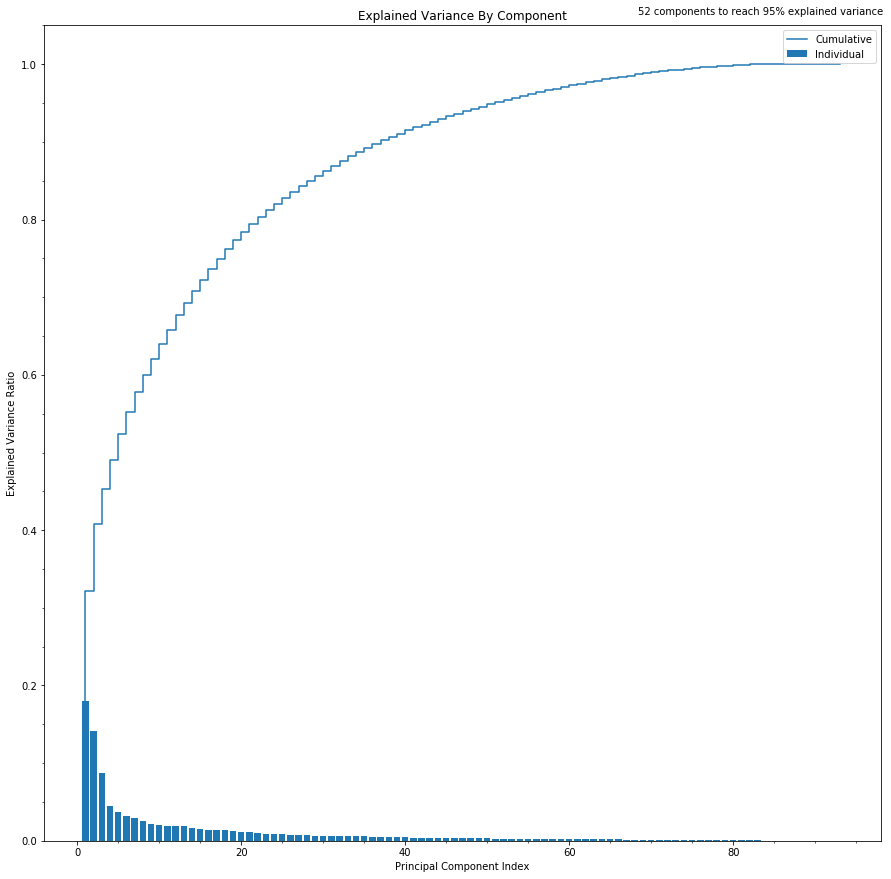

In [74]:
# Plot explained variance for no-parameter PCA
plot_exp_var(pca_none)

In [75]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_comp_52 = PCA(n_components = 52) # Manual selection
pca_var_95 = PCA(n_components = 0.95, svd_solver = 'full') # Variance-based selection

# Fit and transform for selected n_components
comp_52 = pca_comp_52.fit(azdias_clean)
azdias_pca_52 = comp_52.transform(azdias_clean)

var_95 = pca_var_95.fit_transform(azdias_clean)

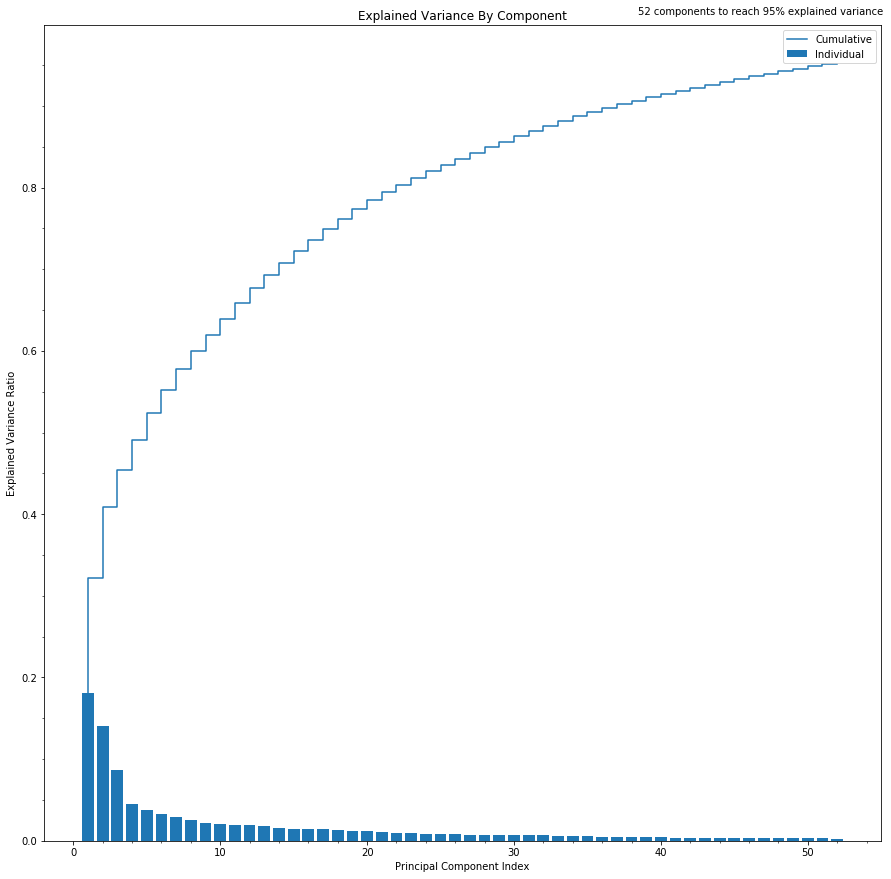

In [76]:
# Plot explained variance for manual selection PCA
plot_exp_var(pca_comp_52)

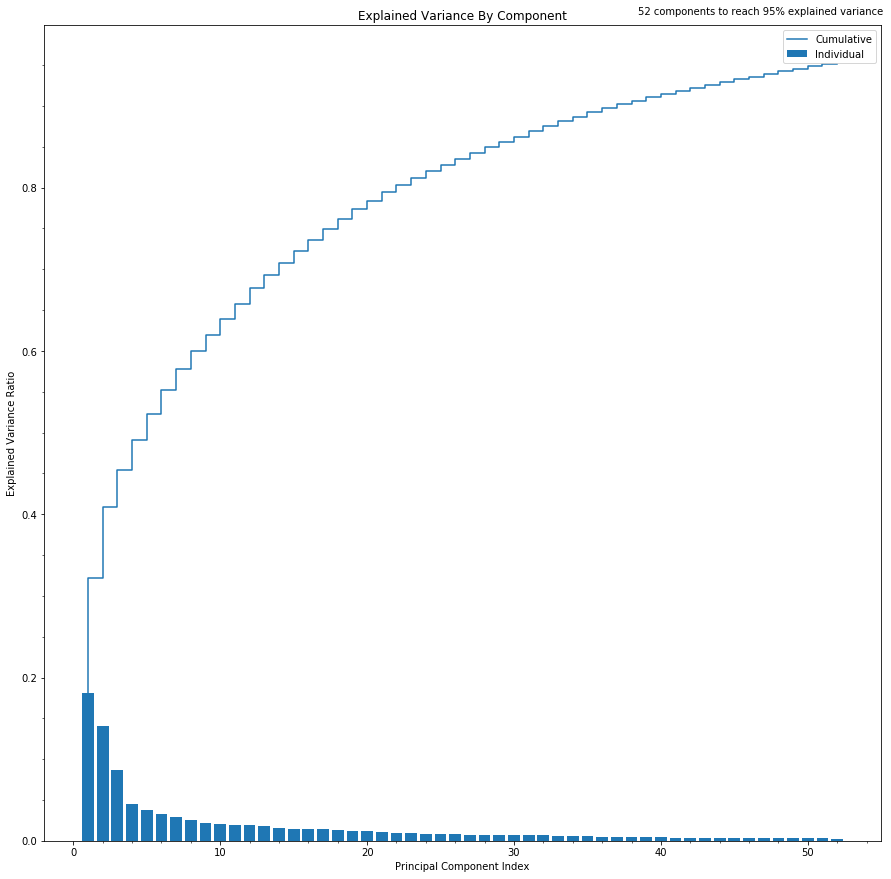

In [77]:
# Plot explained variance for variance-based selection PCA
plot_exp_var(pca_var_95)

### Discussion 2.2: Perform Dimensionality Reduction

Fitting PCA with no parameters kept all 94 features as individual components. Explained variance exceeds 95% at component 52. Given the purpose of our analysis, 95% seems an adequate amount of explained variance. A higher rate might be called for were we doing medical research, but for identifying potential customers, the 95% model will likely serve us better as it will better generalize.

I performed two additional PCA fittings. The first uses manual selection of the number of components (per project instructions), while the second automatically selects the number of components based on the desired explained variance. The two fittings are identical, as demonstrated when plotting them, with the second included only because this is the preferred methodology in most data analysis contexts.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [78]:
# Define function to map features to weights
def map_weights(pca_vers, pc_idx, df, print_mode):
    '''
    Return type is determined by print_mode argument. Argument print_mode accepts either 'list' or 'plot'.
    'list' prints a list all features and their weights for the given component in descending order
    by the weight's absolute value.
    'plot' plots a horizontal bar chart of the 15 most heavily weighted features and their weight values
    in descending order by the weight's absolute value.
    
    The pc_idx argument takes the index of the component to be analyzed. So to analyze the first component
    pc_idx should be 0.
    '''
    
    # Generate dataframe mapping features to weights
    new_df = pd.DataFrame(columns = ['Feature', 'Weight', 'Abs_Val'])
    new_df['Feature'] = df.columns
    new_df['Weight'] = pca_vers.components_[pc_idx]
    new_df['Abs_Val'] = np.abs(new_df['Weight']) # Calculate absolute value of weights
    new_df.sort_values(by = ['Abs_Val'], ascending = False, inplace = True) # Order by absolute value
    new_df.reset_index(drop = True, inplace = True)
    
    # Print feature/weight list
    if print_mode == 'list':
        print(new_df)
    
    # Plot 15 most heavily weighted features
    elif print_mode == 'plot':
        strongest_weights = new_df.head(15).copy()
        # Setting order to ascending as bar chart plots according to index value
        strongest_weights.sort_values(by = ['Abs_Val'], inplace = True)
        strongest_weights.reset_index(drop = True, inplace = True)
        
        # Generate plot
        plt.figure(figsize = (10, 7))
        plt.barh(strongest_weights.index, strongest_weights['Weight'])
        plt.yticks(strongest_weights.index, strongest_weights['Feature'])
        plt.title('Most Heavily Weighted Features in Component')
        plt.ylabel('Feature Name')
        plt.xlabel('Weight (Distance from 0)')
        plt.show()
        
    else:
        print("Invalid print mode. Please enter either 'list' or 'plot'.")

In [79]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_weights(pca_comp_52, 0, azdias_clean, 'list')

                 Feature        Weight       Abs_Val
0             MOBI_REGIO -2.339917e-01  2.339917e-01
1            KBA05_ANTG1 -2.182441e-01  2.182441e-01
2             PLZ8_ANTG1 -2.178275e-01  2.178275e-01
3             PLZ8_ANTG3  2.169376e-01  2.169376e-01
4      FINANZ_MINIMALIST -2.135670e-01  2.135670e-01
5             PLZ8_ANTG4  2.103978e-01  2.103978e-01
6              KBA05_GBZ -2.087279e-01  2.087279e-01
7              CI_WEALTH  2.016735e-01  2.016735e-01
8        CAMEO_DEUG_2015  1.958893e-01  1.958893e-01
9     HH_EINKOMMEN_SCORE  1.910311e-01  1.910311e-01
10           ORTSGR_KLS9  1.891156e-01  1.891156e-01
11              EWDICHTE  1.864273e-01  1.864273e-01
12              PLZ8_GBZ -1.628416e-01  1.628416e-01
13           KONSUMNAEHE -1.600976e-01  1.600976e-01
14            INNENSTADT -1.577301e-01  1.577301e-01
15         FINANZ_SPARER  1.485607e-01  1.485607e-01
16           KBA05_ANTG4  1.472666e-01  1.472666e-01
17      FINANZ_HAUSBAUER  1.460801e-01  1.4608

In [80]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_weights(pca_comp_52, 1, azdias_clean, 'list')

                  Feature        Weight       Abs_Val
0    ALTERSKATEGORIE_GROB  2.575710e-01  2.575710e-01
1               SEMIO_REL -2.540794e-01  2.540794e-01
2               PJ_DECADE -2.385880e-01  2.385880e-01
3           SEMIO_PFLICHT -2.349672e-01  2.349672e-01
4           FINANZ_SPARER -2.317033e-01  2.317033e-01
5             SEMIO_TRADV -2.291924e-01  2.291924e-01
6        FINANZ_VORSORGER  2.264182e-01  2.264182e-01
7   FINANZ_UNAUFFAELLIGER -2.245717e-01  2.245717e-01
8               SEMIO_ERL  2.210968e-01  2.210968e-01
9          FINANZ_ANLEGER -2.067729e-01  2.067729e-01
10             SEMIO_KULT -2.051946e-01  2.051946e-01
11             SEMIO_LUST  1.795444e-01  1.795444e-01
12              SEMIO_RAT -1.779238e-01  1.779238e-01
13         RETOURTYP_BK_S  1.676544e-01  1.676544e-01
14      ONLINE_AFFINITAET -1.657612e-01  1.657612e-01
15              SEMIO_FAM -1.640541e-01  1.640541e-01
16              SEMIO_MAT -1.479174e-01  1.479174e-01
17         W_KEIT_KIND_HH  1

In [81]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_weights(pca_comp_52, 2, azdias_clean, 'list')

                  Feature        Weight       Abs_Val
0              SEMIO_VERT  3.699241e-01  3.699241e-01
1              SEMIO_KAEM -3.633847e-01  3.633847e-01
2               SEMIO_DOM -3.392364e-01  3.392364e-01
3              SEMIO_KRIT -2.954746e-01  2.954746e-01
4               SEMIO_SOZ  2.841749e-01  2.841749e-01
5               SEMIO_FAM  2.766221e-01  2.766221e-01
6              SEMIO_KULT  2.564405e-01  2.564405e-01
7               SEMIO_RAT -2.162988e-01  2.162988e-01
8               ANREDE_KZ -1.939228e-01  1.939228e-01
9               SEMIO_ERL -1.937336e-01  1.937336e-01
10         FINANZ_ANLEGER -1.831393e-01  1.831393e-01
11      FINANZ_MINIMALIST  1.641180e-01  1.641180e-01
12         RETOURTYP_BK_S  1.107123e-01  1.107123e-01
13              SEMIO_REL  1.002627e-01  1.002627e-01
14              PJ_DECADE -1.001633e-01  1.001633e-01
15          FINANZ_SPARER -9.533691e-02  9.533691e-02
16         W_KEIT_KIND_HH  9.464109e-02  9.464109e-02
17       FINANZ_VORSORGER  9

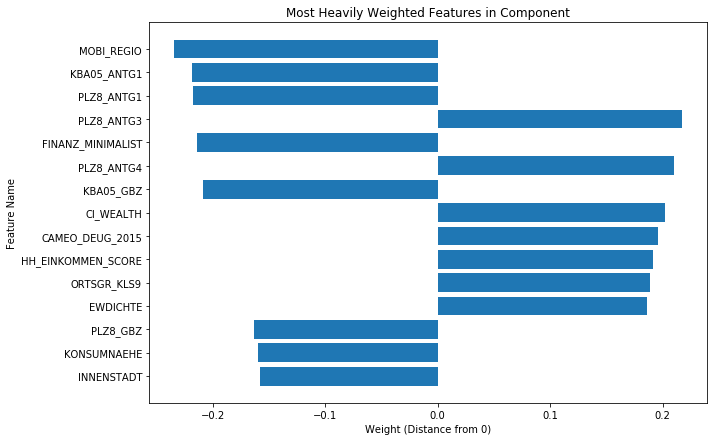

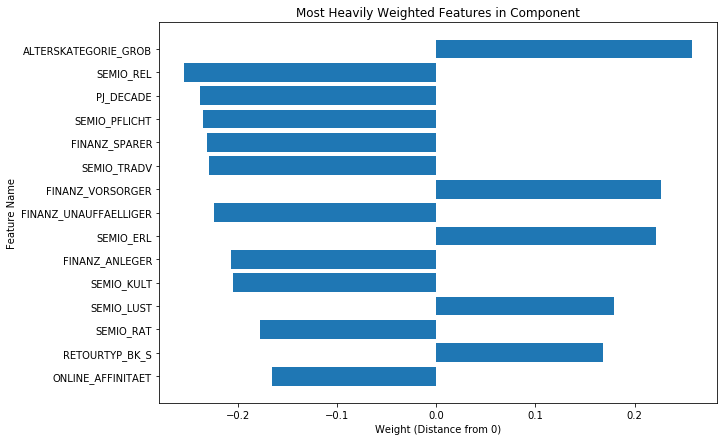

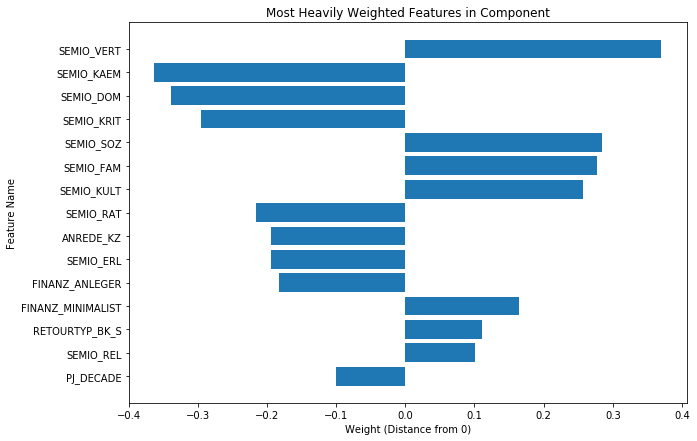

In [82]:
# Plotting for easier analysis
map_weights(pca_comp_52, 0, azdias_clean, 'plot')
map_weights(pca_comp_52, 1, azdias_clean, 'plot')
map_weights(pca_comp_52, 2, azdias_clean, 'plot')

### Discussion 2.3: Interpret Principal Components

To map and analyze the weights each component has given to each feature, I created a function that takes the fitted PCA, the index of the component to be analyzed, the dataframe the PCA was fitted to, and either 'list' or 'plot' to determine the return type. The function first creates a dataframe columns for the feature name, assigned weight, and the absolute value of the weight. The dataframe is then sorted in descending order according to the absolute value of the weight. The absolute value is used because the strength of a weight is determined by how far it is from zero, regardless of whether it's positive or negative.

Selecting 'list' for the print_mode argument returns the contents of this dataframe. But scrolling through 93 item long lists of values expressed via scientific notation isn't exactly intuitive, hence the the 'plot' option for print_mode. This option plots the 15 most heavily-weighted features in the selected component. The strength of the weight is shown in this plot by the distance from zero at which the feature's bar ends. Whether the bar reaches into the positive or negative is irrelevant to the strength of the weight (though not to the weight's effect), and the sorting of the plot reflects that.

It is important to look at the data dictionary (updated version) when interpreting the meaning of these weights. While it may be intuitive to assume that a strong negative weight indicates that individuals strongly associated with that feature are the ones being grouped, that may not be the case. In this dataset there are a large number of ordinal values whose categories are in descending order. In these cases, the negative weight exists to punish individuals weakly associated with the feature. Any feature with a descending ordinal structure will be labelled as such in the detailed analysis.

#### Strongest Weights

**Principal Component 1**

The weights in this first component appear to be grouuping individuals living in areas with higher population density (e.g. urban areas, cities) with lower incomes. Many urban areas and city centers have a high proportion of lower-income households, so it makes sense that a component that heavily weighs them would also heavily weigh lower incomes.

*Features Relating to Population Density*

These features are all ascending ordinals.

2. KBA05_ANTG1 - Number of 1-2 family homes in micro-cell
3. PLZ8_ANTG1 - Number of 1-2 family homes in macro-cell

Areas with high population density are unlikely to have large numbers of single or dual family homes. As such, these features are assigned a negative weight.

4. PLZ8_ANTG3 - Number of 6-10 family homes in macro-cell
6. PLZ8_ANTG4 - Number of 10+ family homes in macro-cell

On the other hand, areas with high population density are very likely to have homes designed to house several families (e.g. apartments or condos), so these features are positively weighted.

7. KBA05_GBZ - Number of buildings in micro-cell
13. PLZ8_GBZ - Number of buildings in macro-cell

These features being negatively weighted may seem odd at first. Certainly a high-density area would have more buildings, right? Well, not necessarily. High-density areas often use fewer buildings designed to house more residents/businesses. Given the weights of the features above, that is likely the case for the regions reflected in these features.

11. ORTSGR_KLS9 - Size of community
12. EWDICHTE - Household density

Again we have positive weights for features indicating high population density. We would expect to see positive weights on the number of people or households in a given area based on the weights of the housing type features, and that's exactly what we have here.

14. KONSUMNAEHE - Distance from building to point of sale
15. INNENSTADT - Distance to city center

Generally speaking, as one moves further away from a city center, population density goes down. And since most sellers want their stores where large numbers of people can easily access them, both of these features receive a negative weight.

*Features Relating to Wealth/Income*

These features are all descending ordinals.

5. FINANZ_MINIMALIST - low financial interest

The negative weight here is selecting for individuals who are less interested in finances (e.g. saving, investing, etc.). This lack of interest could derive from any number of influences, but the strong weights of the three features below implies that these individuals and households may simply not have enough money to make saving or investing worthwhile.

8. CI_WEALTH - German CAMEO: Wealth Typology
9. CAMEO_DEUG_2015 - German CAMEO: Wealth / Life Stage Typology
10. HH_EINKOMMEN_SCORE - Estimated household net income

These three features all have positive weights, indicating that the individual or household has less money on hand or regularly coming in.

*Unclear*

1. MOBI_REGIO - Movement patterns

This is another descending ordinal. Its strong negative score indicates that individuals with higher movement patterns are being selected for. Without knowing exactly what is meant by 'movement pattern' (it's not specified in the data dictionary), it is difficult to say whether this fits with the themes of the other features strongly weighted in this component. If its in reference to amount of traffic in the region, that could fit with our theme of high population density, but this is just speculation.

**Principal Component 2**

The weights in this component appear to be selecting based on age, personality, and financial habits. Specifically, it seems to be selecting for older individuals who are more conservative in their views and finances. Attitudes towards money and many of the personality traits measured in these features often trend with particular age groups. It's very likely that these features are heavily weighted here because of such trends and are also selecting for age.

*Age*

1. ALTERSKATEGORIE_GROB - Estimated age based on given name analysis
3. PJ_DECADE - Dominating movement of person's youth (decade)

The positive weight on estimated age and negative weight on movement decade both serve to select for older individuals. Decade receives a negative weight despite being an ascending ordinal as more recent decades indicate younger participants.

*Personality*

2. SEMIO_REL - Religious
4. SEMIO_PFLICHT - Dutiful
6. SEMIO_TRADV - Traditional-minded
11. SEMIO_KULT - Cultural-minded
13. SEMIO_RAT - Rational

These five personality traits are all descending ordinals with negative weights. Given the global trend of younger generations moving away from religion<sup>3</sup> and towards multiculturalism<sup>4</sup>, these features are likely also selecting for older individuals.

9. SEMIO_ERL - Event-oriented
12. SEMIO_LUST - Sensual-minded

These two personality traits are also descending ordinals, but they have received positive weights. Given how the other features in this component select for age, these features may be more associated with younger individuals and are being selected against.

15. ONLINE_AFFINITAET - Online affinity

Younger individuals generally have a larger online presence than those of older generations, having grown up alongside the World Wide Web. As such, this feature receives a negative weight.

*Financial Habits*

All five of these finance-related features are descending ordinals.

5. FINANZ_SPARER - Money-saver
8. FINANZ_UNAUFFAELLIGER - Inconspicuous
10. FINANZ_ANLEGER - Investor

The negative weights on these three features seem to be selecting for individuals who are conservative and future-minded in their finances. These individuals may spend less in the now with expectations of long-term divindends.

7. FINANZ_VORSORGER - Be prepared

Again the vagueness of the data dictionary makes interpretation difficult. One would expect someone described as "be[ing] prepared" to line up with the type of person selected for by the above financial habit features, but that's not the case here. This feature receives a positive weight and without knowing exactly what is meant by "be prepared", it's hard to say why.

14. RETOURTYP_BK_S - Return type

The positive weight of this feature, however, does line up nicely with the cautious consumer outlined by the first three finance features. Positively weighting this descending ordinal selects against those who do more shopping/returning and for those who do less.

**Principal Component 3**

Like component 2, this component also heavily weights a number of personality traits. However these traits seem to be less influenced by age than component 2 and more so by gender. The target of this component appears to be practicality-focused older males.

Every feature listed below, with the exception of ANREDE_KZ and PJ_DECADE, is a descending ordinal.

*Personality*

Positive weights:

1. SEMIO_VERT - Dreamful
5. SEMIO_SOZ - Socially-minded
6. SEMIO_FAM - Family-minded
7. SEMIO_KULT - Cultural-minded
14. SEMIO_REL - Religious

Negative weights:

2. SEMIO_KAEM - Combative attitude
3. SEMIO_DOM - Dominant-minded
4. SEMIO_KRIT - Critical-minded
8. SEMIO_RAT - Rational
10. SEMIO_ERL - Event-oriented

Taken together, the weights of these features appear to be selecting for people who are more practical-minded and individualistic. Traits such as 'dreamful' and 'socially-minded' are punished with positive weights, while traits like 'rational' and 'dominant-minded' are boosted with negative weights.

*Finance Habits*

11. FINANZ_ANLEGER - Investor
12. FINANZ_MINIMALIST - Low financial interest

It's interesting that both 'investor' and 'low financial interest' receive negative weights in this component. One could reasonably assume that if someone has little interest in finances, then they'd be unlikely to make investments. That both of these features are being selected for in the same component may be cause to doubt that assumption.

13. RETOURTYP_BK_S

The positive weight on this feature again selects for a more cautious shopper; one who buys and makes returns less often.

9. ANREDE_KZ - Gender<sup>5</sup>

This feature is a binary, with 0 for male and 1 for female. Given this encoding, the negative value here is selecting for males over females.

15. PJ_DECADE - Dominating movement of person's youth (decade)

Much like in component 2, this feature receives a negative weight in order to select for older individuals, though to a lesser degree. And unlike in component 2, this is the only feature directly related to age to be in the top 15 weights for this component.

#### Weakest Weights

Interestingly, the first three components have similar weakly-weighted features. In fact all three have GBTYP_COMMERCIAL as the weakest feature and SOHO_KZ as the second weakest. It would appear that whether or not an individual is located in a commercial building or has a small/home office has very little to do with which segment they'll fall into. Whether or not the occupant of a building is known also seems to be largely unimportant, with it being in the bottom three features of PC3 and the bottom five of PC2. The structure and social status of the individual's family also appear to have fairly little impact on segmentation. Most, if not all, categories from both LP_FAMILIE_GROB_X and LP_STATUS_GROB_X appear in the bottom 20 features of each component.

There are two features that the components weight very differently. While PC1 and PC2 both place most or all of the categories for shopper and energy consumption typologies (SHOPPER_TYP_X & ZABEOTYP_X) in their bottom 20, PC3 gives them more middling weights just below its top 25.

*Footnotes*

3. Pew Research. (2018, June 13). 2. Young adults around the world are less religious by several measures. Pew Research Center’s Religion & Public Life Project. Retrieved August 29, 2022, from https://www.pewresearch.org/religion/2018/06/13/young-adults-around-the-world-are-less-religious-by-several-measures/
4. Harris, Anita. (2013). Young People and Everyday Multiculturalism. Young People and Everyday Multiculturalism. 1-164. 10.4324/9780203082980.
5. The data dictionary labels this field "Gender", but the use of 'male' and 'female' indicates that the field is actually measuring assigned sex.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [83]:
# Define function to model and score KMeans
def kmeans_eval(data, num_clusters):
    
    # Instantiate and fit model
    kmeans = KMeans(n_clusters = num_clusters)
    model = kmeans.fit(data)
    
    # Score model
    score = np.abs(model.score(data)) # Taking absolute value of score for ease of comparison
    
    return score

In [84]:
# Run modeling/scoring function for multiple values of num_cluster
scores = []
num_clusters = list(range(10, 31, 5))

for val in num_clusters:
    scores.append(kmeans_eval(azdias_pca_52, val))

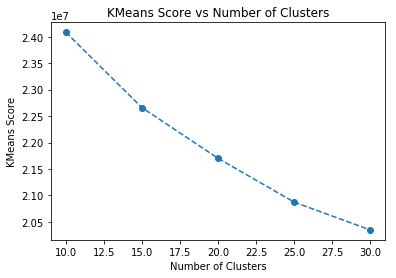

In [85]:
# Investigate the change in within-cluster distance across number of clusters
plt.plot(num_clusters, scores, linestyle='--', marker='o')
plt.title('KMeans Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('KMeans Score')
plt.show();

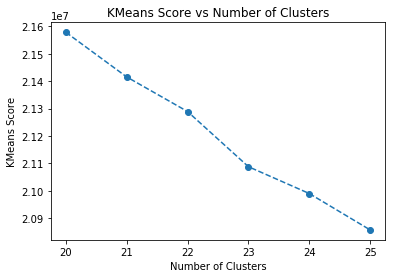

In [86]:
# Run comparison again on narrower range
scores = []
num_clusters = list(range(20, 26))

for val in num_clusters:
    scores.append(kmeans_eval(azdias_pca_52, val))
    
plt.plot(num_clusters, scores, linestyle='--', marker='o')
plt.title('KMeans Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('KMeans Score')
plt.show();

In [87]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# Instantiate and fit model for final cluster count
kmeans_final = KMeans(n_clusters = 23)
kmeans_model = kmeans_final.fit(azdias_pca_52)

# Predict clustering
azdias_predicts = kmeans_final.predict(azdias_pca_52)

In [88]:
# Create new dataframe and assign cluster predictions to new column
azdias_final = azdias_clean.copy()
azdias_final['SEGMENT'] = azdias_predicts

# View value counts for segments
azdias_final.SEGMENT.value_counts()

10    39794
16    35979
9     34613
18    34576
14    34411
8     34268
19    33563
2     32919
0     32378
1     32274
3     31611
12    31207
5     30227
7     30147
4     30123
21    25647
20    25338
11    25087
6     21892
17    20009
22    19395
13     2494
15      519
Name: SEGMENT, dtype: int64

### Discussion 3.1: Apply Clustering to General Population

To determine the optimal number of clusters, a function is defined that will take the dataset and a value for n_clusters, fit a model to them, and return the absolute value of the model's score. The absolute value is used because sklearn's score() function scores according to distance from 0 (i.e. a score of X is equivalent to a score of -X). This function is then run in a for loop iterating over a list of values for n_clusters and saving each model's score to an array. The array of scores is then plotted as a scree plot to analyze the effectiveness of the models.

This for loop is run twice in order to minimize processing time and resource overhead. The first loop uses a list of values with a range of 10 to 31 using a step of 5. 10 and 31 were chosen based on the project instructions. Rather than fitting 21 models, setting a step of 5 allows for only five models to fitted. Once these five models are fitted, scored, and plotted, the plot can be used to determine what range of values should be used in the second loop.

In this case, the first plot indicates that diminshing returns on score improvement starts somewhere between 20 and 25 (inclusive) clusters. The second loop uses this range and a step of 1 to fit and score these models, which are then plotted to get our optimal number of clusters. Using this two loop methodology cut the number of models needing to be fitted by almost half.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [89]:
# Load in and clean the customer demographics data
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')
customers_clean = clean_data(customers)

In [90]:
# Drop & impute missing values
imp_missing(customers_clean, mf_cols, med_cols)
drop_list = []
for col in customers_clean.columns:
    if (col not in mf_cols) | (col not in med_cols):
        drop_list.append(col)
customers_clean.dropna(subset = drop_list, inplace = True)

# Scale data
customers_clean[scale_cols] = scale_df(customers_clean)

# Verify imputation and scaling successful
customers_clean.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,...,ZABEOTYP_5,ZABEOTYP_6,GTYP_KNOWN_OCCUPANT,GTYP_RESIDENTIAL,GTYP_COMMERCIAL,GTYP_MIXED_USE,PJ_MOVETYP,PJ_DECADE,CI_WEALTH,CI_HOUSEHOLD
6,2.0,1.161533,0,1.426644,-1.12906,1.104796,-1.214587,-1.131051,-0.863110,1942.0,...,0,0,1.0,1.0,0.0,0.0,1.0,-1.599190,-0.919683,0.087744
7,1.0,1.161533,0,1.426644,-1.12906,1.104796,-1.214587,-0.402062,-0.863110,1938.0,...,0,0,1.0,1.0,0.0,0.0,1.0,-1.599190,-1.605327,1.418815
11,1.0,1.161533,0,1.426644,-1.12906,1.104796,-1.214587,0.326927,-0.863110,1943.0,...,0,0,1.0,1.0,0.0,0.0,1.0,-1.599190,-1.605327,0.753279
14,2.0,1.161533,1,-0.046543,-1.12906,1.104796,-1.214587,-0.402062,1.329388,1923.0,...,0,0,1.0,1.0,0.0,0.0,0.0,-2.286864,1.137249,-1.243326
15,2.0,0.189735,0,1.426644,-1.12906,1.104796,-1.214587,-1.131051,-0.863110,1953.0,...,0,0,1.0,1.0,0.0,0.0,1.0,-0.911517,-1.605327,1.418815


In [91]:
# Drop columns not present in azdias_clean 
drop_labels = []

for col in customers_clean.columns:
    if col not in azdias_clean.columns:
        drop_labels.append(col)

customers_clean.drop(columns = drop_labels, inplace = True)

# Verify column lists match
customers_clean.columns == azdias_clean.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [101]:
# Transform using PCA model for demographics
customers_pca_52 = comp_52.transform(customers_clean)

# Predict clustering using model for demographics
customers_predicts = kmeans_final.predict(customers_pca_52)

# Create new dataframe and assign cluster predictions to new column
customers_final = customers_clean.copy()
customers_final['SEGMENT'] = customers_predicts

# View value counts for segments
customers_final.SEGMENT.value_counts()

8     4721
17    3650
12    2139
5     2097
19    1507
3      940
1      630
20     558
11     525
2      468
13     438
14     345
21     154
10     146
7       76
9       71
16      39
0       23
22      16
15      13
6        8
18       6
4        4
Name: SEGMENT, dtype: int64

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

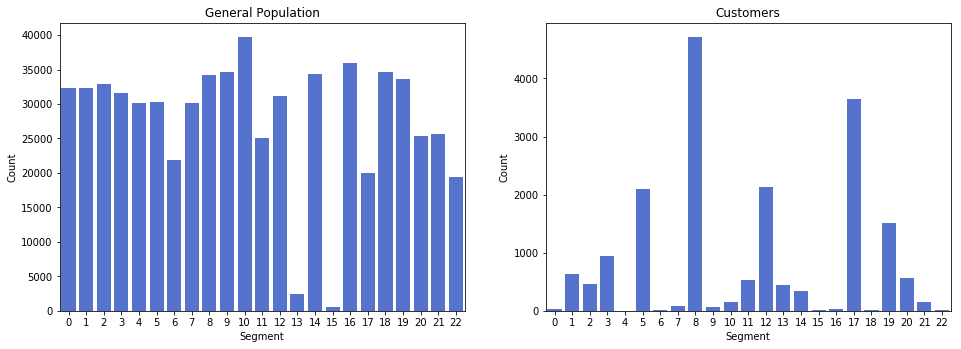

In [93]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
plt.figure(figsize = (9, 5))
 
# Plot for general demographics
plt.subplot(1, 2, 1)
sns.countplot(x = 'SEGMENT', data = azdias_final, color = 'royalblue')
plt.title('General Population')
plt.xlabel('Segment')
plt.ylabel('Count')
    
# Plot for customers
plt.subplot(1, 2, 2)
sns.countplot(x = 'SEGMENT', data = customers_final, color = 'royalblue')
plt.title('Customers')
plt.xlabel('Segment')
plt.ylabel('Count')
    
plt.subplots_adjust(bottom=0.1, right=1.5, top=0.9)
plt.show()

In [94]:
# Define function to generate dataframe comparing segment proportions
def segment_portions(df1, df2):
    '''
    Takes the general population and customer dataframes as arguments.
    Returns new dataframe comparing the proportion of each dataset each segment represents.
    New dataframe is sorted so that underrepresented segments are listed first and
    overrepresented ones are listed last.
    '''
    
    new_df = pd.DataFrame(columns = ['Segment', 'Gen_Pop_Count', 'Cust_Count', 'Gen_Pop_Proportion',
                                     'Cust_Proportion', 'Proportion_Diff'])
    new_df['Segment'] = list(range(0,23))
    
    # Frequency counts for each segment in each dataset
    new_df['Gen_Pop_Count'] = df1.SEGMENT.value_counts().sort_index()
    new_df['Cust_Count'] = df2.SEGMENT.value_counts().sort_index()
    
    # Proportion of dataset segment represents (multiplied by 100 to act as percentage)
    new_df['Gen_Pop_Proportion'] = (new_df['Gen_Pop_Count'] / df1.shape[0]) * 100
    new_df['Cust_Proportion'] = (new_df['Cust_Count'] / df2.shape[0]) * 100
    
    # Difference in proportions between datasets
    new_df['Proportion_Diff'] = new_df['Gen_Pop_Proportion'] - new_df['Cust_Proportion']
    
    # Sort by difference in propotion
    new_df.sort_values(by = 'Proportion_Diff', ascending = False, inplace = True)
    new_df.reset_index(drop = True, inplace = True)
    
    return new_df

In [95]:
# Generate segment comparison dataframe
comparison_df = segment_portions(azdias_final, customers_final)

# View summary statistics for Proportion_Diff
comparison_df['Proportion_Diff'].describe()

count    2.300000e+01
mean    -1.544658e-16
std      6.765737e+00
min     -2.005005e+01
25%     -1.038652e+00
50%      2.636260e+00
75%      4.504515e+00
max      5.446658e+00
Name: Proportion_Diff, dtype: float64

In [96]:
# Define function to determine over/underrepresented segments by IQR
def over_under_rep_iqr(df):
    # Determine outlier thresholds
    Q1 = df['Proportion_Diff'].quantile(0.25)
    Q3 = df['Proportion_Diff'].quantile(0.75)
    IQR = Q3 - Q1
    high_thresh = Q3 + (1.5 * IQR)
    low_thresh = Q1 - (1.5 * IQR)
    
    # Arrays to hold selected segments
    over_rep = []
    under_rep = []
    
    # Check for outliers and place in correct array
    s = 0
    while s < df.shape[0]:
        if df['Proportion_Diff'][s] >= high_thresh:
            over_rep.append(df['Segment'][s])
        elif df['Proportion_Diff'][s] <= low_thresh:
            under_rep.append(df['Segment'][s])
        s += 1
            
    return over_rep, under_rep

# Define function to determine over/underrepresented segments by manually selected threshold
def over_under_rep_manual(df, val):
    # Select outlier thresholds
    high_thresh = val
    low_thresh = 0-val
    
    # Arrays to hold selected segments
    over_rep = []
    under_rep = []
    
    # Check for outliers and place in correct array
    s = 0
    while s < df.shape[0]:
        if df['Proportion_Diff'][s] >= high_thresh:
            over_rep.append(df['Segment'][s])
        elif df['Proportion_Diff'][s] <= low_thresh:
            under_rep.append(df['Segment'][s])
        s += 1
            
    return over_rep, under_rep

In [97]:
# Determine over/underrepresented segments by IQR
over_rep_i, under_rep_i = over_under_rep_iqr(comparison_df)

print(over_rep_i, under_rep_i)

[] [17, 8]


In [98]:
# Determine over/underrepresented segments by manually selected threshold
over_rep_m, under_rep_m = over_under_rep_manual(comparison_df, 5)

print(over_rep_m, under_rep_m)

[10, 16, 18, 9] [5, 12, 17, 8]


In [102]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
cluster_centroid_10 = scale_model.inverse_transform(pca_comp_52.inverse_transform(
    kmeans_model.cluster_centers_[10]))

ValueError: operands could not be broadcast together with shapes (93,) (59,) (93,) 

In [ ]:
map_weights(pca_comp_52, 0, azdias_clean, 'plot')

In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
print(under_rep)

In [ ]:
map_weights(pca_comp_52, 0, azdias_clean, 'plot')

### Discussion 3.3: Compare Customer Data to Demographics Data

Using the traditional outlier formulas of $Q_1-(1.5*IQR)$ and $Q_3+(1.5*IQR)$ turns out to be too inclusive for our purposes, flagging only two segments as underrepresented in the customer data and none as overrepresented. Using a manually selected threshold allows us to be stricter in how we define disproportionate representation. Based on the values for Proportion_Diff across all segments, I chose to set my threshold at $\pm5$. This threshold returned eight segments, four overrepresented and four underrepresented. These segments are listed in the two sections below, with each list in descending order of disproportionality.

#### Overrepresented

1. 10

2. 9

3. 19

4. 7

#### Underrepresented

1. 2

2. 17

3. 6

4. 12

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.